In [ ]:
!pip install pandas matplotlib statsmodels  scikit-learn torch xgboost
!pip uninstall -y numpy pmdarima
!pip install --no-cache-dir numpy==1.23.5 scipy statsmodels pandas
!pip install --no-cache-dir pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.3 MB/s eta 0:00:00


Para el XGBoost hace falta haber ejecutado el código del GRU, se instala la versión más estable de numpy para el pmdarima porque puede dar errores esporádicos en otras versiones de numpy

# T2M ARIMAX

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2539.134, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=441.167, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6740.469, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6771.453, Time=1.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4257.975, Time=1.77 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6768.538, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2524.340, Time=0.19 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 4.323 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1582
Model:               SARIMAX(1, 0, 1)   Log Likelihood                3389.726
Date:                Tue, 08 Apr 2025   AIC                          -6771.453
Time:                        16:28:05

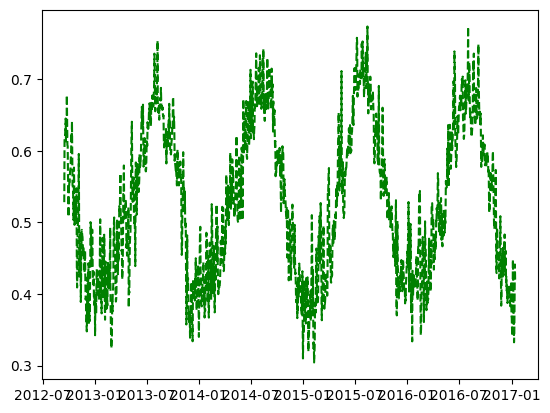

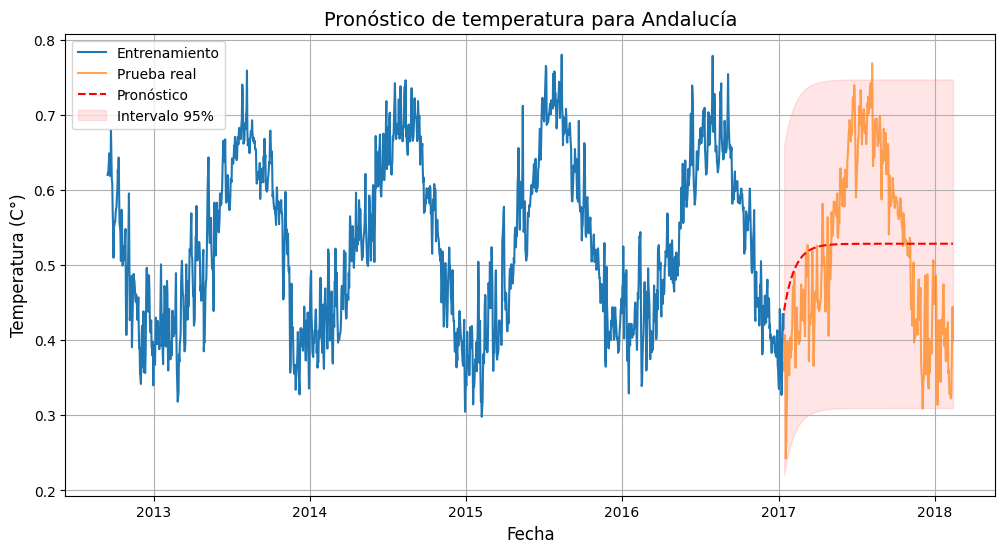

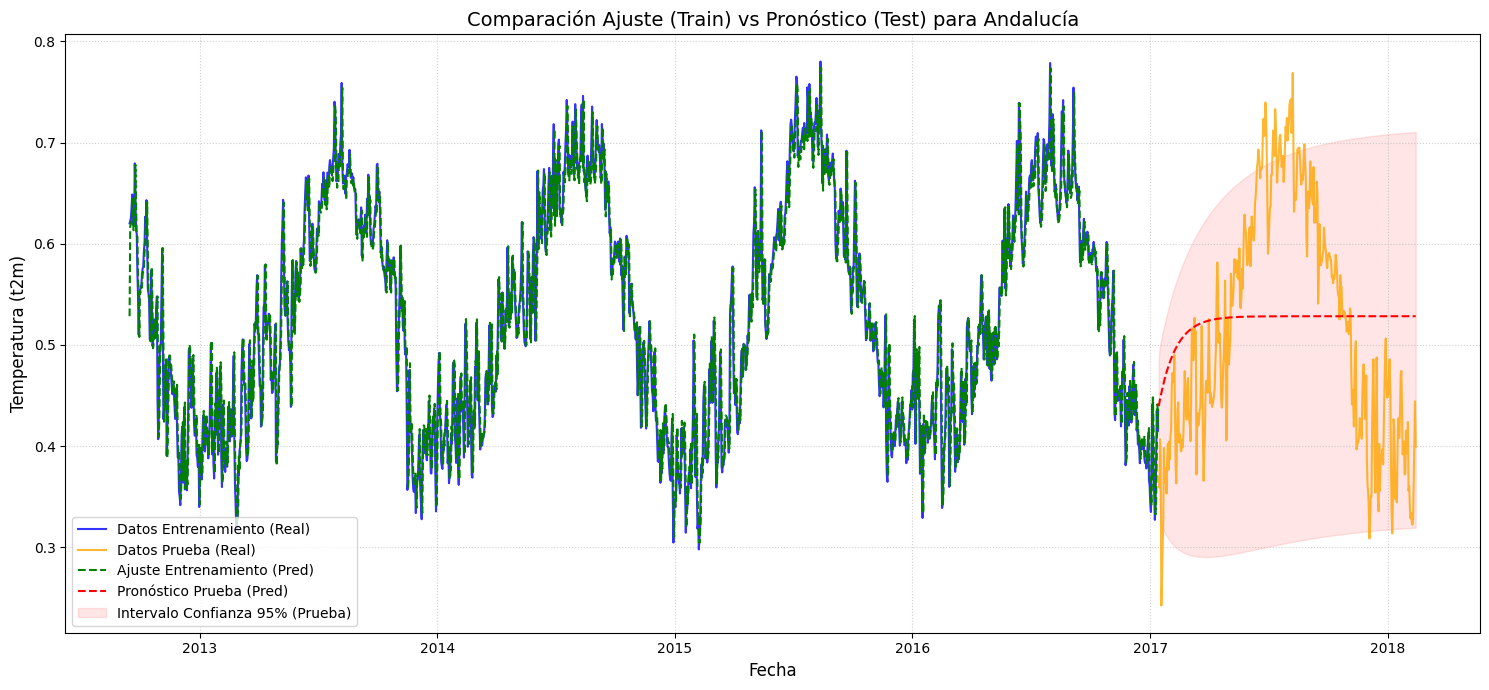

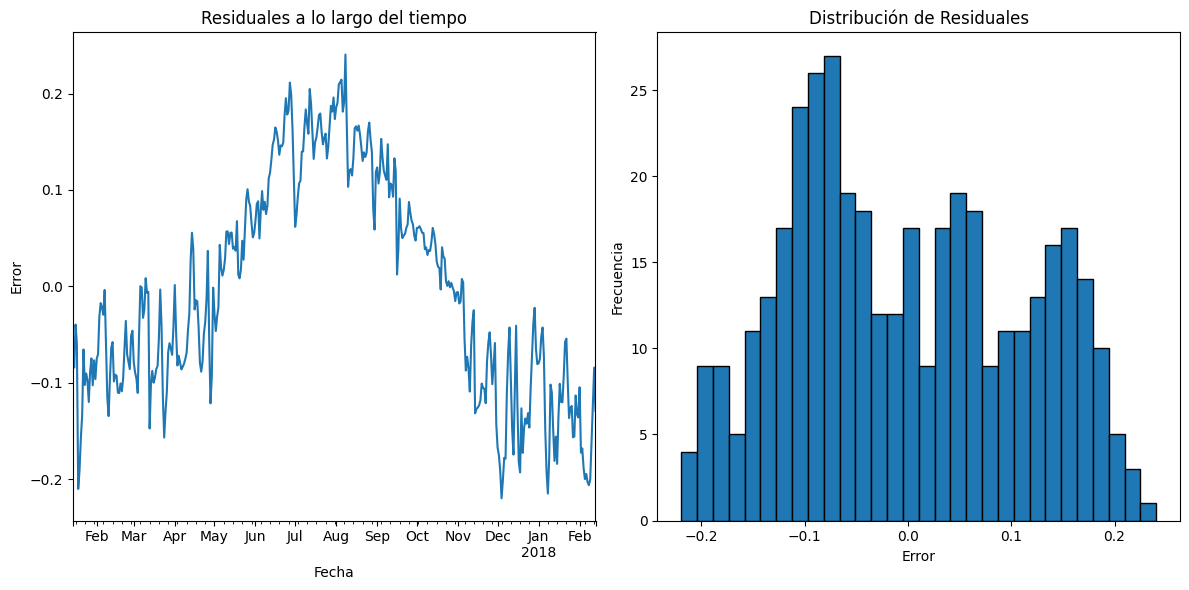

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

# 1. Carga de datos
df = pd.read_csv('/content/drive/MyDrive/datasets/Datos_normalizados_corregido.csv',
                 sep=",", header=0, parse_dates=['time'])

# 2. 'time' al día
df['time'] = df['time'].dt.floor('d')

# 3. Características cíclicas
df['dayofweek'] = df['time'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 4. Agrupamos por día y ubicación
df_grouped = df.groupby(['time', 'Nombre_loc'], as_index=False).mean()
df_grouped = df_grouped.sort_values(by=['time', 'Nombre_loc']).reset_index(drop=True)

# 5. Extraemos datos para una ubicación específica
ubicacion = df_grouped['Nombre_loc'].unique()[0]
ubicacion_data = df_grouped[df_grouped['Nombre_loc'] == ubicacion].set_index('time')

# Seleccionar variable objetivo
ts_target = ubicacion_data['t2m'].dropna()

# 6. Dividimos en train/test
train_size = int(len(ts_target) * 0.8)
train, test = ts_target.iloc[:train_size], ts_target.iloc[train_size:]

# 7. Búsqueda de modelo optimizada
modelo_auto = pm.auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    max_order=2,     # Máximo orden total
    start_p=0,       # Inicio del orden autoregresivo
    max_p=1,         # Máximo orden autoregresivo
    start_q=0,       # Inicio del orden del promedio móvil
    max_q=1,         # Máximo orden del promedio móvil
    information_criterion='aic',
    n_jobs=-1
)


print(modelo_auto.summary())

# 8. Ajustar modelo ARIMA
order = modelo_auto.order
modelo_arima = ARIMA(train, order=order)
modelo_fit = modelo_arima.fit()
print(modelo_fit.summary())

# 9. Pronóstico
forecast_steps = len(test)
forecast = modelo_fit.forecast(steps=forecast_steps)

# Predicción sobre entrenamiento
train_pred = modelo_fit.fittedvalues



# 10. Cálculo de métricas
def calculate_metrics(pred, actual):
    metrics = {
        'RMSE': np.sqrt(np.mean((pred - actual) ** 2)),
        'MAE': mean_absolute_error(actual, pred),
        'R2': r2_score(actual, pred),
        'MAPE': np.mean(np.abs((actual - pred) / actual)) * 100
    }
    return metrics

metrics = calculate_metrics(forecast, test)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
train_metrics = calculate_metrics(train_pred, train)
print("\nMétricas en entrenamiento:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
plt.plot(train.index, modelo_fit.fittedvalues, label='Ajuste entrenamiento', color='green', linestyle='--')

# 11. Visualización general de pronóstico
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba real', alpha=0.7)
plt.plot(test.index, forecast, label='Pronóstico', color='red', linestyle='--')
plt.fill_between(test.index,
                 forecast - 1.96*np.std(forecast - test),
                 forecast + 1.96*np.std(forecast - test),
                 color='red', alpha=0.1, label='Intervalo 95%')
plt.title(f'Pronóstico de temperatura para {ubicacion}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (C°)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))

# Datos reales
plt.plot(train.index, train, label='Datos Entrenamiento (Real)', color='blue', alpha=0.8)
plt.plot(test.index, test, label='Datos Prueba (Real)', color='orange', alpha=0.8)

# Predicciones del modelo
plt.plot(train_pred.index, train_pred, label='Ajuste Entrenamiento (Pred)', color='green', linestyle='--')
plt.plot(test.index, forecast, label='Pronóstico Prueba (Pred)', color='red', linestyle='--')

# Sombreado del intervalo de confianza para el pronóstico
plt.fill_between(test.index,
                 conf_int.iloc[:, 0], # Límite inferior
                 conf_int.iloc[:, 1], # Límite superior
                 color='red', alpha=0.1, label='Intervalo Confianza 95% (Prueba)')

plt.title(f'Comparación Ajuste (Train) vs Pronóstico (Test) para {ubicacion}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (t2m)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout() # Ajusta para que no se solapen elementos
plt.show()
# 12. Análisis residual
residuals = test - forecast
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
residuals.plot(title='Residuales a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Distribución de Residuales')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


**Prueba con GRID SEARCH**

--- 1. Cargando Datos ---
Datos cargados correctamente. Forma inicial: (13102272, 12)
--- 2. Ajustando Fecha a Día ---
--- 4. Agrupando Datos por Día y Ubicación ---
Datos agrupados. Forma: (15824, 18)
--- 5. Seleccionando Datos de una Ubicación ---
Datos seleccionados para la ubicación: Andalucía. Número de registros: 1978
Variable objetivo 't2m' seleccionada. Puntos: 1978
--- 6. Dividiendo en Conjuntos de Entrenamiento y Prueba ---
Tamaño Entrenamiento: 1582, Tamaño Prueba: 396

--- (Opcional) Análisis de Estacionariedad ---
ADF p-value: 0.2639
Sugerencia: La serie parece NO estacionaria (p > 0.05). Considera incluir d=1 en tu Grid Search.

--- 7. Iniciando Grid Search para ARIMA(p,d,q) ---
Probando 9 combinaciones de (p,d,q)...
  > Nuevo mejor orden encontrado: (0, 1, 0) con RMSE (Test): 0.1441
  > Nuevo mejor orden encontrado: (0, 1, 1) con RMSE (Test): 0.1435
  > Nuevo mejor orden encontrado: (2, 1, 2) con RMSE (Test): 0.1119

Grid Search completado en 7.84 segundos.

--- Mejor or

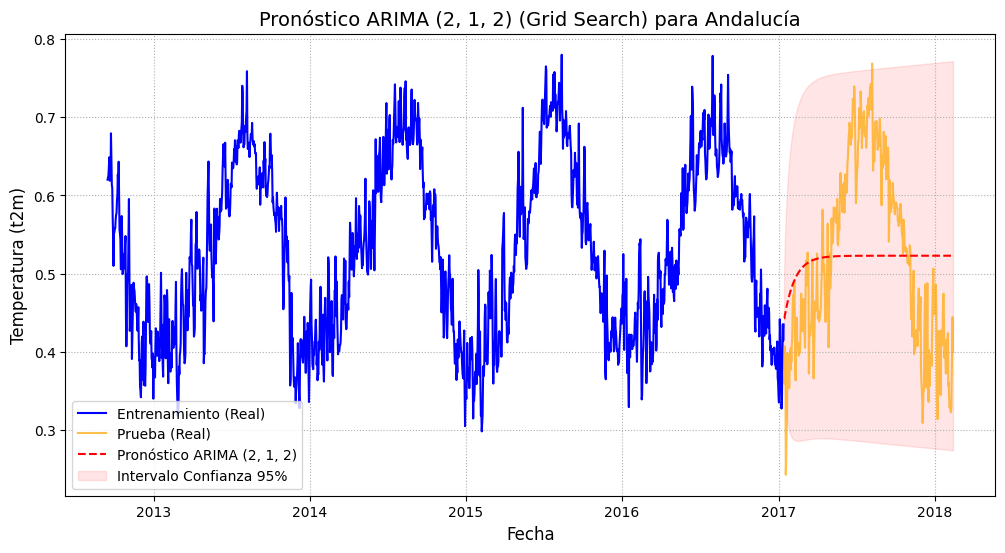

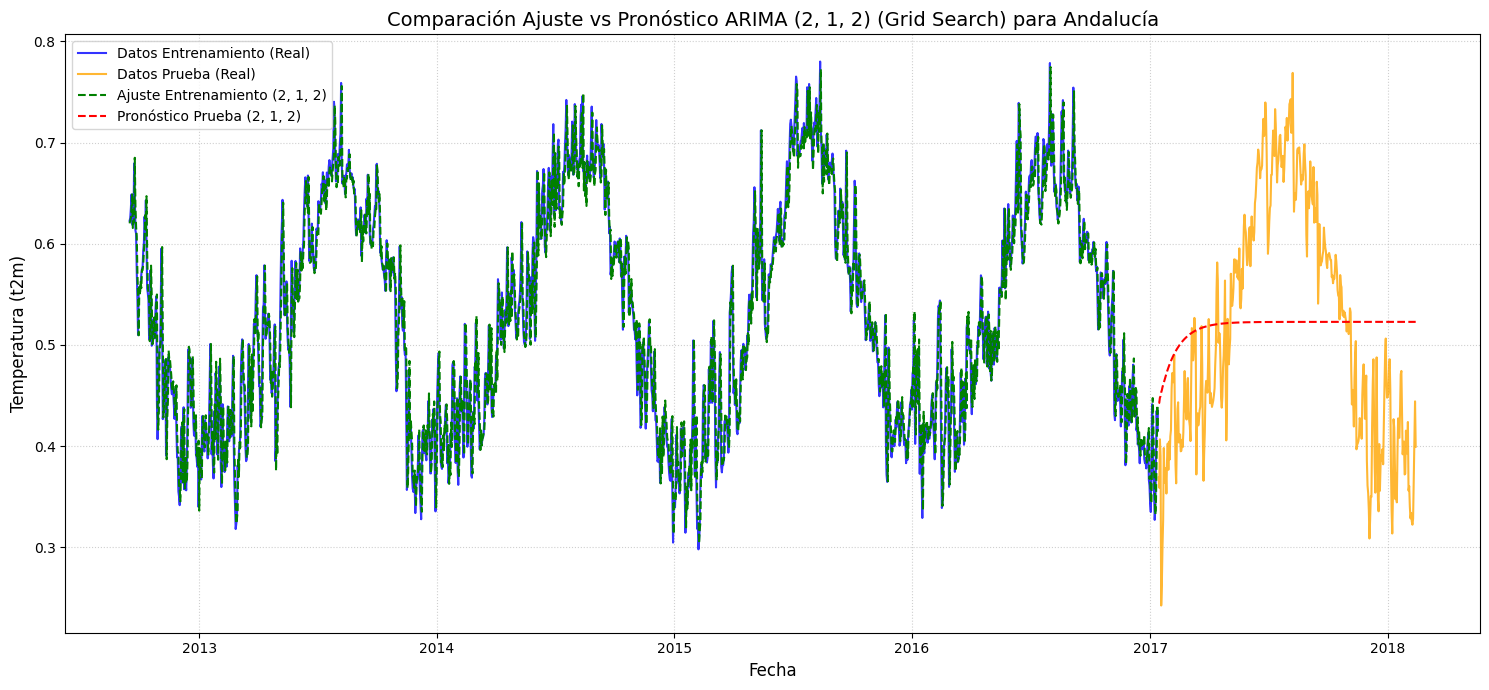


--- 12. Análisis de Residuales del Modelo Final (Grid Search) ---


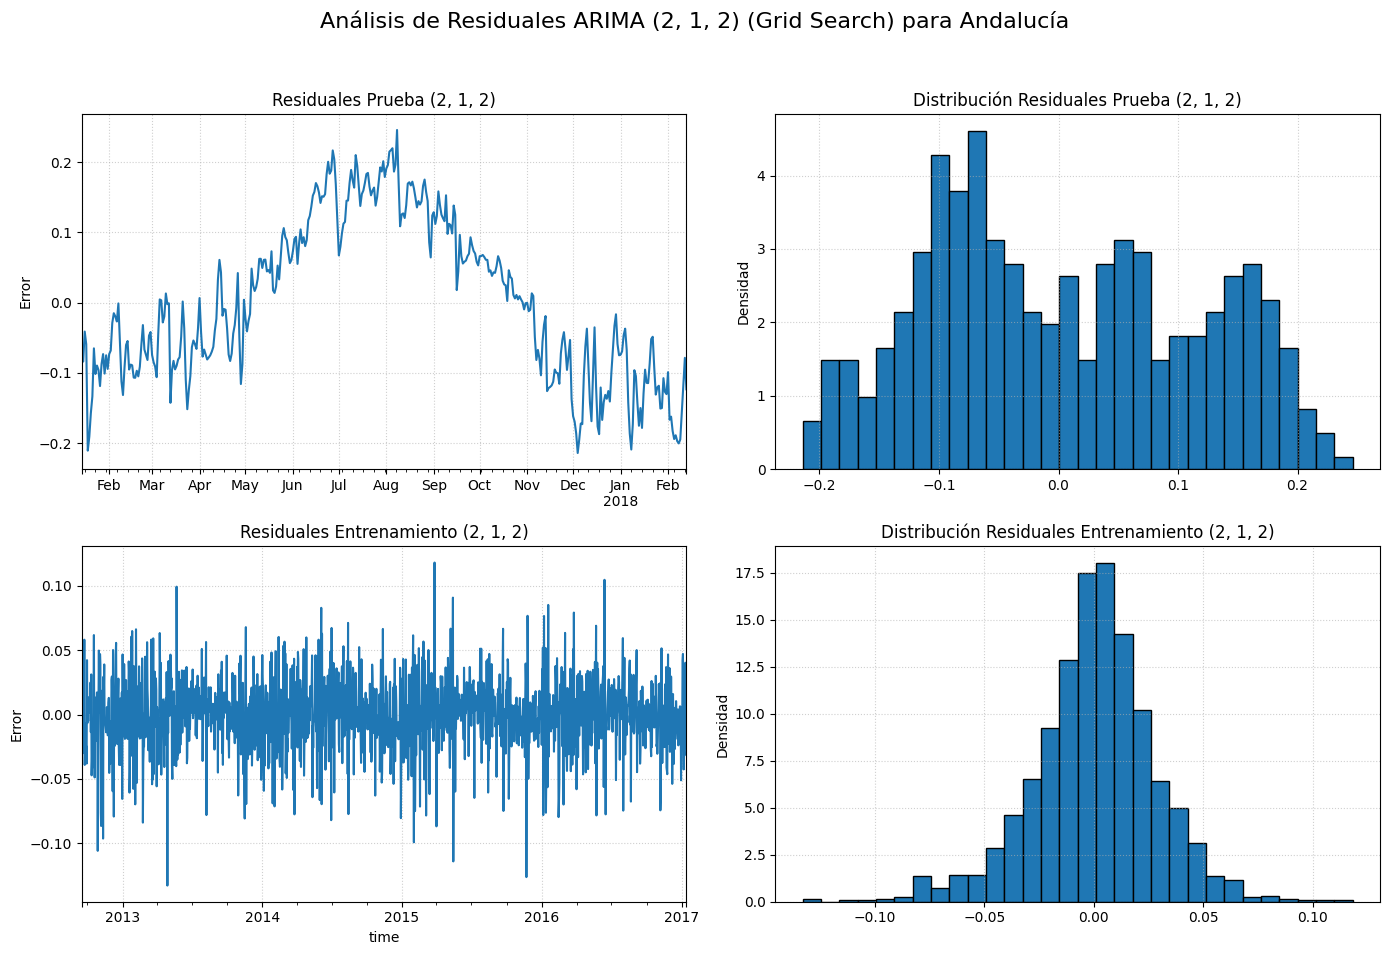


--- Proceso Completado (con Grid Search) ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warningsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from itertools import product
import time

warnings.filterwarnings("ignore")

# --- Configuración ---
FILE_PATH = '/content/drive/MyDrive/datasets/Datos_normalizados_corregido.csv'

# --- 1. Carga de datos ---
print("--- 1. Cargando Datos ---")
try:
    df = pd.read_csv(FILE_PATH, sep=",", header=0, parse_dates=['time'])
    print(f"Datos cargados correctamente. Forma inicial: {df.shape}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo CSV en la ruta: {FILE_PATH}")
    exit()
except Exception as e:
    print(f"Error al cargar el CSV: {e}")
    exit()

# --- 2. 'time' al día ---
print("--- 2. Ajustando Fecha a Día ---")
df['time'] = df['time'].dt.floor('d')

# --- 3. Características cíclicas (Mantenidas, aunque no usadas por ARIMA) ---
# print("--- 3. Creando Características Cíclicas ---")
df['dayofweek'] = df['time'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# --- 4. Agrupamos por día y ubicación ---
print("--- 4. Agrupando Datos por Día y Ubicación ---")
try:
    df_grouped = df.groupby(['time', 'Nombre_loc'], as_index=False).mean(numeric_only=True)
    df_grouped = df_grouped.sort_values(by=['time', 'Nombre_loc']).reset_index(drop=True)
    print(f"Datos agrupados. Forma: {df_grouped.shape}")
except Exception as e:
    print(f"Error durante la agrupación: {e}")
    exit()

# --- 5. Extraemos datos para una ubicación específica ---
print("--- 5. Seleccionando Datos de una Ubicación ---")
if df_grouped['Nombre_loc'].nunique() > 0:
    ubicacion = df_grouped['Nombre_loc'].unique()[0]
    ubicacion_data = df_grouped[df_grouped['Nombre_loc'] == ubicacion].set_index('time')
    print(f"Datos seleccionados para la ubicación: {ubicacion}. Número de registros: {len(ubicacion_data)}")
else:
    print("Error: No se encontraron ubicaciones únicas.")
    exit()
ts_target = ubicacion_data['t2m'].dropna()
print(f"Variable objetivo 't2m' seleccionada. Puntos: {len(ts_target)}")
MIN_DATA_POINTS = 50
if len(ts_target) < MIN_DATA_POINTS:
    print(f"Error: Muy pocos datos ({len(ts_target)}). Se necesitan al menos {MIN_DATA_POINTS}.")
    exit()

# --- 6. Dividimos en train/test ---
print("--- 6. Dividiendo en Conjuntos de Entrenamiento y Prueba ---")
train_size = int(len(ts_target) * 0.8)
train, test = ts_target.iloc[:train_size], ts_target.iloc[train_size:]
print(f"Tamaño Entrenamiento: {len(train)}, Tamaño Prueba: {len(test)}")

if train.empty or test.empty:
    print("Error: Conjuntos train o test vacíos.")
    exit()

print("\n--- (Opcional) Análisis de Estacionariedad ---")
try:
    adf_result = adfuller(train)
    print(f'ADF p-value: {adf_result[1]:.4f}')
    if adf_result[1] > 0.05:
        print("Sugerencia: La serie parece NO estacionaria (p > 0.05). Considera incluir d=1 en tu Grid Search.")
        default_d_range = [1]
    else:
        print("Sugerencia: La serie parece ESTACIONARIA (p <= 0.05). Considera incluir d=0 en tu Grid Search.")
        default_d_range = [0]
except Exception as e:
    print(f"Error en prueba ADF: {e}. Usando d=0 y d=1 por defecto.")
    default_d_range = [0, 1]


#-------------------------------------------------------------
# 7. GRID SEARCH PARA ARIMA(p,d,q)
#-------------------------------------------------------------
print("\n--- 7. Iniciando Grid Search para ARIMA(p,d,q) ---")

# Define los rangos para p, d, q que quieres probar
p_range = range(0, 3)
d_range = default_d_range
q_range = range(0, 3)

# Genera todas las combinaciones posibles de (p, d, q)
pdq_combinations = list(product(p_range, d_range, q_range))
print(f"Probando {len(pdq_combinations)} combinaciones de (p,d,q)...")

best_score = float('inf')
best_order = None
results = [] # Para guardar resultados si quieres analizarlos después

start_time_grid = time.time()

# Itera sobre cada combinación
for order in pdq_combinations:

    try:
        # Ajusta el modelo ARIMA
        temp_model = ARIMA(train, order=order)
        temp_model_fit = temp_model.fit()

        # Genera pronósticos en el conjunto de prueba
        forecast_steps = len(test)
        temp_forecast = temp_model_fit.forecast(steps=forecast_steps)E
        common_index = test.index.intersection(temp_forecast.index)
        if common_index.empty:
            print(f"Orden {order}: Sin índices comunes para evaluación. Saltando.")
            continue

        actual_aligned = test.loc[common_index]
        pred_aligned = temp_forecast.loc[common_index]

        # Filtrar NaNs/Infs
        mask = np.isfinite(pred_aligned) & np.isfinite(actual_aligned)
        pred_clean = pred_aligned[mask]
        actual_clean = actual_aligned[mask]

        if len(pred_clean) == 0:
            # print(f"Orden {order}: Sin puntos válidos tras limpiar NaNs. Saltando.")
            continue

        # Calcular RMSE
        current_rmse = np.sqrt(mean_squared_error(actual_clean, pred_clean))
        results.append({'order': order, 'test_rmse': current_rmse})

        # Actualizar si se encuentra un mejor RMSE
        if current_rmse < best_score:
            best_score = current_rmse
            best_order = order
            print(f"  > Nuevo mejor orden encontrado: {best_order} con RMSE (Test): {best_score:.4f}")

    except Exception as e:

        continue # Pasa a la siguiente combinación

end_time_grid = time.time()
print(f"\nGrid Search completado en {end_time_grid - start_time_grid:.2f} segundos.")

if best_order is None:
    print("\nError: Grid Search no encontró ningún modelo válido. Revisa los rangos de p,d,q o los datos.")
    exit() # Salir si no se encontró ningún modelo


print(f"\n--- Mejor orden encontrado por Grid Search: {best_order} (RMSE Test: {best_score:.4f}) ---")


# --- 8. Ajustar modelo ARIMA FINAL con el mejor orden encontrado ---
print(f"\n--- 8. Ajustando ARIMA FINAL con orden: {best_order} ---")
try:
    modelo_arima_final = ARIMA(train, order=best_order)
    modelo_fit_final = modelo_arima_final.fit()
    print(modelo_fit_final.summary())
except Exception as e:
    print(f"Error al ajustar el modelo ARIMA final con orden {best_order}: {e}")
    exit()

# --- 9. Pronóstico con el modelo final ---
print("\n--- 9. Generando Pronósticos Finales ---")
try:
    forecast_result_final = modelo_fit_final.get_forecast(steps=len(test))
    forecast_final = forecast_result_final.predicted_mean
    conf_int_final = forecast_result_final.conf_int(alpha=0.05)
    train_pred_final = modelo_fit_final.fittedvalues

    # Alinear para cálculo de métricas si d>0
    if best_order[1] > 0:
        train_subset_for_comparison = train.iloc[best_order[1]:]
        common_index_train = train_subset_for_comparison.index.intersection(train_pred_final.index)
        train_subset_for_comparison = train_subset_for_comparison.loc[common_index_train]
        train_pred_final = train_pred_final.loc[common_index_train]
    else:
        train_subset_for_comparison = train
        common_index_train = train_subset_for_comparison.index.intersection(train_pred_final.index)
        train_subset_for_comparison = train_subset_for_comparison.loc[common_index_train]
        train_pred_final = train_pred_final.loc[common_index_train]

except Exception as e:
    print(f"Error durante la generación de pronósticos o predicciones de entrenamiento finales: {e}")
    exit()

# --- 10. Cálculo de métricas para el modelo final ---
print("\n--- 10. Calculando Métricas del Modelo Final (Grid Search) ---")

def calculate_metrics_robust(pred, actual, model_type="Test"):
    if pred is None or actual is None:
        print(f"Advertencia: Datos de entrada ({model_type}) nulos.")
        return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'MAPE': np.nan}
    common_index = actual.index.intersection(pred.index)
    if common_index.empty:
        print(f"Advertencia: No hay índices comunes ({model_type}).")
        return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'MAPE': np.nan}
    actual_aligned = actual.loc[common_index]
    pred_aligned = pred.loc[common_index]
    mask = np.isfinite(pred_aligned) & np.isfinite(actual_aligned)
    pred_clean = pred_aligned[mask]
    actual_clean = actual_aligned[mask]
    if len(pred_clean) == 0:
        print(f"Advertencia: No hay puntos válidos tras limpiar ({model_type}).")
        return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'MAPE': np.nan}
    rmse = np.sqrt(mean_squared_error(actual_clean, pred_clean))
    mae = mean_absolute_error(actual_clean, pred_clean)
    try:
      r2 = r2_score(actual_clean, pred_clean)
    except ValueError:
      r2 = np.nan
    actual_nonzero_mask = actual_clean != 0
    if np.sum(actual_nonzero_mask) > 0:
        mape = np.mean(np.abs((actual_clean[actual_nonzero_mask] - pred_clean[actual_nonzero_mask]) / actual_clean[actual_nonzero_mask])) * 100
    else:
        mape = np.nan
    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    return metrics

print("\nMétricas en Prueba (Test):")
metrics_test_final = calculate_metrics_robust(forecast_final, test, "Test")
for metric, value in metrics_test_final.items():
    print(f"  {metric}: {value:.4f}")
print("\nMétricas en Entrenamiento (Train):")
metrics_train_final = calculate_metrics_robust(train_pred_final, train_subset_for_comparison, "Train")
for metric, value in metrics_train_final.items():
    print(f"  {metric}: {value:.4f}")

# Comparación Overfitting
print("\n--- Comparación Overfitting (Modelo Grid Search) ---")
if metrics_train_final and metrics_test_final and \
   not np.isnan(metrics_train_final.get('RMSE')) and not np.isnan(metrics_test_final.get('RMSE')) and \
   metrics_train_final.get('RMSE', 0) != 0:
    ratio_rmse = metrics_test_final['RMSE'] / metrics_train_final['RMSE']
    print(f"Ratio RMSE (Test / Train): {ratio_rmse:.2f}")
    # Puedes ajustar el umbral según tus criterios
    if ratio_rmse > 2.0: print(" > Advertencia: Posible overfitting.")
    elif ratio_rmse < 0.9: print(" > Comportamiento inusual: Error Train > Test.")
    elif ratio_rmse < 1.0: print(" > Interesante: Error Test < Train.")
    else: print(" > Overfitting parece controlado.")
else:
    print(" > No se pudo comparar overfitting (métricas inválidas).")

# --- 11. Gráficos con el modelo final (de Grid Search) ---
print("\n--- 11. Generando Gráficos del Modelo Final (Grid Search) ---")

# 11a. Visualización general de pronóstico
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento (Real)', color='blue')
plt.plot(test.index, test, label='Prueba (Real)', color='orange', alpha=0.7)
plt.plot(forecast_final.index, forecast_final, label=f'Pronóstico ARIMA {best_order}', color='red', linestyle='--')
if conf_int_final is not None and not conf_int_final.empty:
    common_ci_index = conf_int_final.index.intersection(forecast_final.index)
    if not common_ci_index.empty:
        plt.fill_between(common_ci_index,
                         conf_int_final.loc[common_ci_index].iloc[:, 0],
                         conf_int_final.loc[common_ci_index].iloc[:, 1],
                         color='red', alpha=0.1, label='Intervalo Confianza 95%')
plt.title(f'Pronóstico ARIMA {best_order} (Grid Search) para {ubicacion}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (t2m)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

# 11b. Visualización de Overfitting
plt.figure(figsize=(15, 7))
plt.plot(train_subset_for_comparison.index, train_subset_for_comparison, label='Datos Entrenamiento (Real)', color='blue', alpha=0.8)
plt.plot(test.index, test, label='Datos Prueba (Real)', color='orange', alpha=0.8)
plt.plot(train_pred_final.index, train_pred_final, label=f'Ajuste Entrenamiento {best_order}', color='green', linestyle='--')
plt.plot(forecast_final.index, forecast_final, label=f'Pronóstico Prueba {best_order}', color='red', linestyle='--')
plt.title(f'Comparación Ajuste vs Pronóstico ARIMA {best_order} (Grid Search) para {ubicacion}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (t2m)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


# --- 12. Análisis residual del modelo final (de Grid Search) ---
print("\n--- 12. Análisis de Residuales del Modelo Final (Grid Search) ---")
try:
    # Recalcular residuales asegurando alineación
    common_index_test = test.index.intersection(forecast_final.index)
    residuals_test_final = test.loc[common_index_test] - forecast_final.loc[common_index_test]
    common_index_train_res = train_subset_for_comparison.index.intersection(train_pred_final.index)
    residuals_train_final = train_subset_for_comparison.loc[common_index_train_res] - train_pred_final.loc[common_index_train_res]

    plt.figure(figsize=(14, 10))
    # Residuales de prueba
    ax1 = plt.subplot(2, 2, 1); ax1.set_title(f'Residuales Prueba {best_order}')
    if not residuals_test_final.empty: residuals_test_final.plot(ax=ax1); ax1.grid(True, linestyle=':', alpha=0.6); ax1.set_ylabel("Error")
    ax2 = plt.subplot(2, 2, 2); ax2.set_title(f'Distribución Residuales Prueba {best_order}')
    if not residuals_test_final.empty: residuals_test_final.dropna().hist(ax=ax2, bins=30, edgecolor='k', density=True); ax2.grid(True, linestyle=':', alpha=0.6); ax2.set_ylabel("Densidad")
    # Residuales de entrenamiento
    ax3 = plt.subplot(2, 2, 3); ax3.set_title(f'Residuales Entrenamiento {best_order}')
    if not residuals_train_final.empty: residuals_train_final.plot(ax=ax3); ax3.grid(True, linestyle=':', alpha=0.6); ax3.set_ylabel("Error")
    ax4 = plt.subplot(2, 2, 4); ax4.set_title(f'Distribución Residuales Entrenamiento {best_order}')
    if not residuals_train_final.empty: residuals_train_final.dropna().hist(ax=ax4, bins=30, edgecolor='k', density=True); ax4.grid(True, linestyle=':', alpha=0.6); ax4.set_ylabel("Densidad")

    plt.suptitle(f'Análisis de Residuales ARIMA {best_order} (Grid Search) para {ubicacion}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Error durante el análisis de residuales: {e}")

print("\n--- Proceso Completado (con Grid Search) ---")

# **T2M SARIMAX**

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-6673.006, Time=13.52 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-5256.773, Time=0.58 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-6318.215, Time=5.78 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2493.336, Time=0.39 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-6803.719, Time=6.89 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=-6805.686, Time=6.26 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=-5639.226, Time=7.53 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=-6810.237, Time=5.92 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=-5833.890, Time=6.12 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=-6804.780, Time=8.71 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=-6653.504, Time=10.56 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=-6589.440, Time=4.88 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-6791.926, Time=3.06 sec
 ARIMA(0,0,1)(0,0,0)[7] 

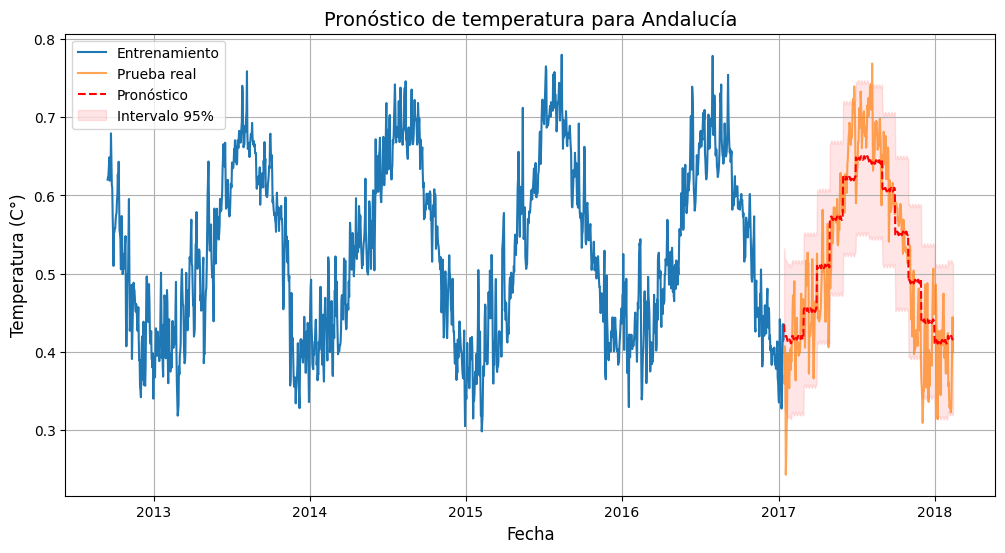

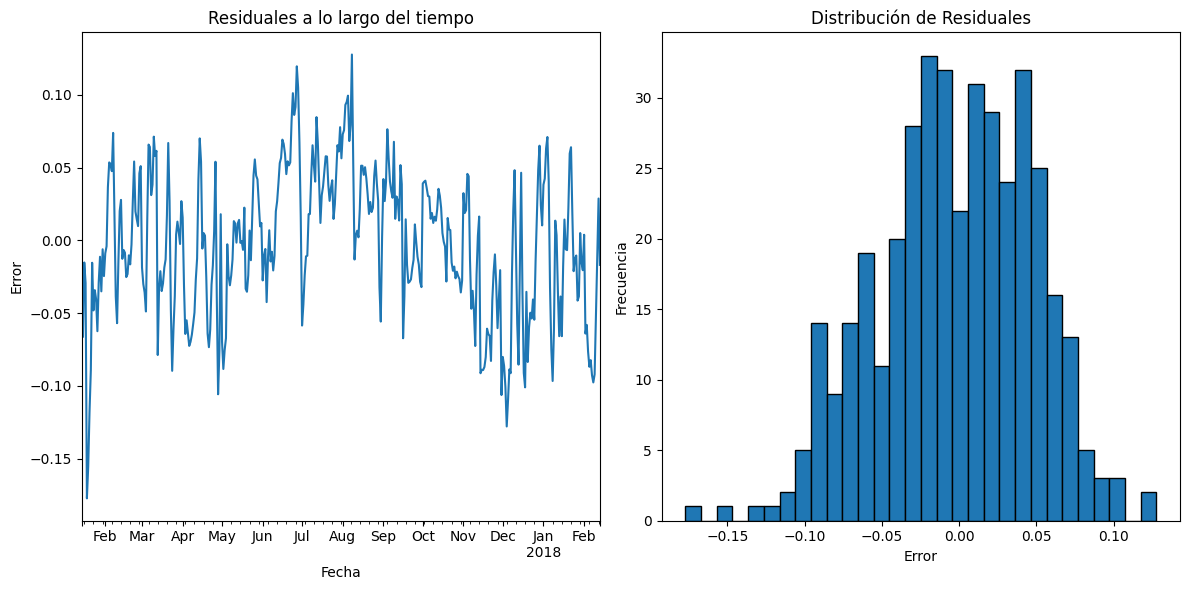

Índices de ventana elegidos (relativos al test): [168, 106, 290, 160, 355]

Ventana de test desde 2017-07-01 hasta 2017-07-05:
 Día 1:
   Real  = 0.5901
   Pred  = 0.6486
 Día 2:
   Real  = 0.6023
   Pred  = 0.6465
 Día 3:
   Real  = 0.6214
   Pred  = 0.6455
 Día 4:
   Real  = 0.6353
   Pred  = 0.6463
 Día 5:
   Real  = 0.6378
   Pred  = 0.6483


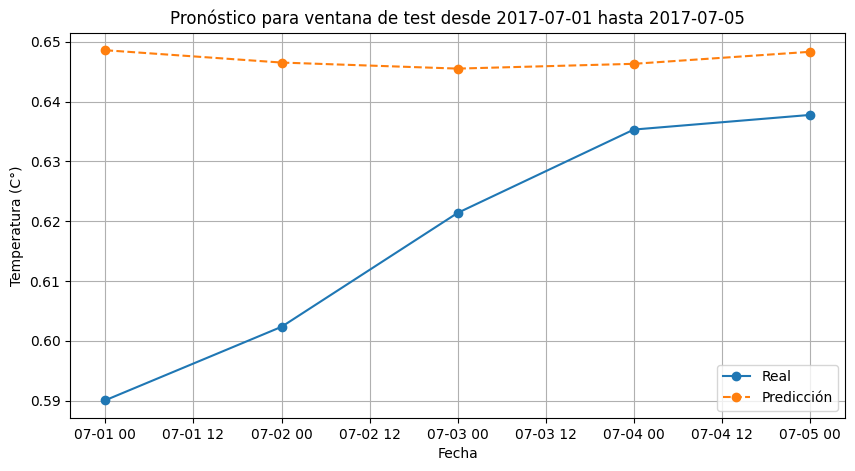


Ventana de test desde 2017-04-30 hasta 2017-05-04:
 Día 1:
   Real  = 0.5258
   Pred  = 0.5078
 Día 2:
   Real  = 0.4989
   Pred  = 0.5684
 Día 3:
   Real  = 0.4809
   Pred  = 0.5692
 Día 4:
   Real  = 0.4958
   Pred  = 0.5712
 Día 5:
   Real  = 0.5058
   Pred  = 0.5730


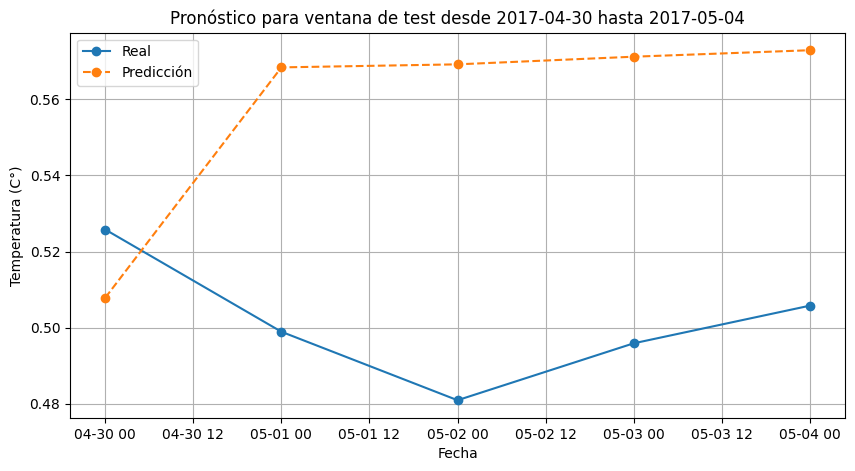


Ventana de test desde 2017-10-31 hasta 2017-11-04:
 Día 1:
   Real  = 0.5222
   Pred  = 0.5498
 Día 2:
   Real  = 0.5226
   Pred  = 0.4902
 Día 3:
   Real  = 0.5107
   Pred  = 0.4919
 Día 4:
   Real  = 0.5128
   Pred  = 0.4921
 Día 5:
   Real  = 0.5362
   Pred  = 0.4905


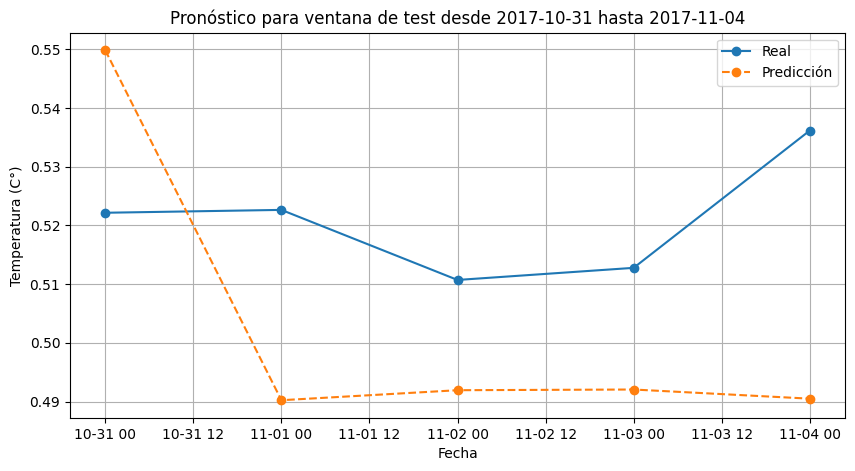


Ventana de test desde 2017-06-23 hasta 2017-06-27:
 Día 1:
   Real  = 0.7056
   Pred  = 0.6238
 Día 2:
   Real  = 0.7234
   Pred  = 0.6223
 Día 3:
   Real  = 0.7064
   Pred  = 0.6202
 Día 4:
   Real  = 0.7108
   Pred  = 0.6192
 Día 5:
   Real  = 0.7396
   Pred  = 0.6200


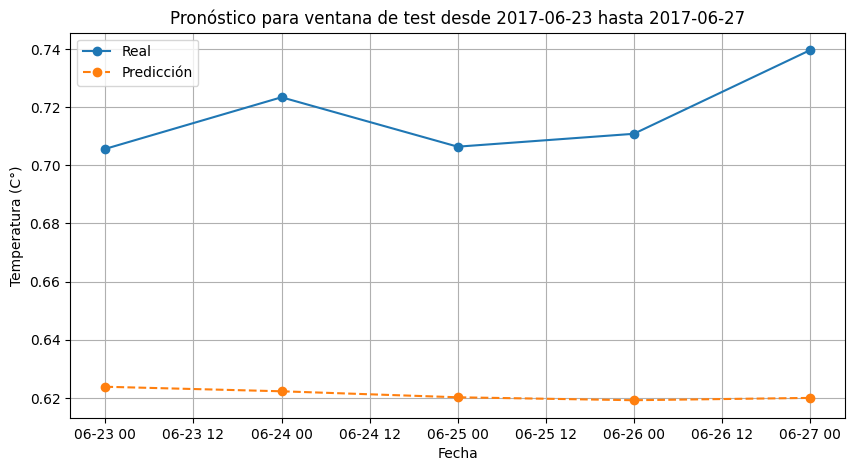


Ventana de test desde 2018-01-04 hasta 2018-01-08:
 Día 1:
   Real  = 0.4859
   Pred  = 0.4149
 Día 2:
   Real  = 0.4558
   Pred  = 0.4150
 Día 3:
   Real  = 0.3810
   Pred  = 0.4134
 Día 4:
   Real  = 0.3366
   Pred  = 0.4114
 Día 5:
   Real  = 0.3137
   Pred  = 0.4104


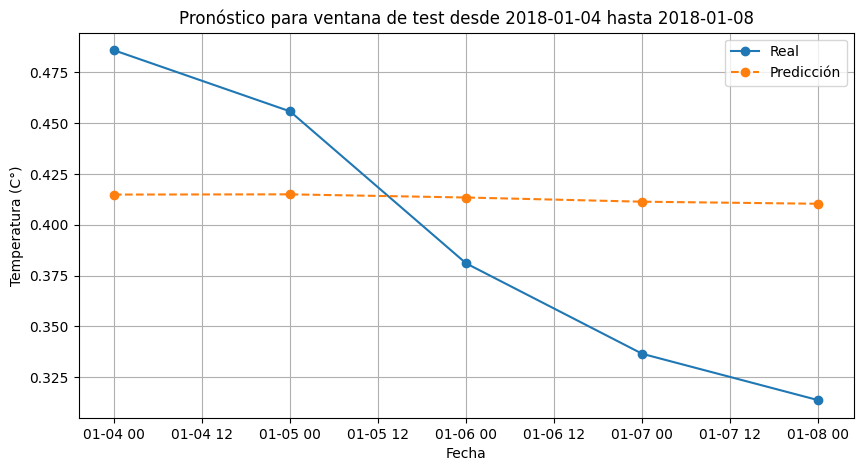

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

# 1. Carga de datos
df = pd.read_csv('/content/drive/MyDrive/datasets/Datos_normalizados_corregido.csv',
                 sep=",", header=0, parse_dates=['time'])

# 2. 'time' al día
df['time'] = df['time'].dt.floor('d')

# 3. Características cíclicas
df['dayofweek'] = df['time'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 4. Agrupamos por día y ubicación
df_grouped = df.groupby(['time', 'Nombre_loc'], as_index=False).mean()
df_grouped = df_grouped.sort_values(by=['time', 'Nombre_loc']).reset_index(drop=True)

# 5. Extraemos datos para una ubicación específica
ubicacion = df_grouped['Nombre_loc'].unique()[0]
ubicacion_data = df_grouped[df_grouped['Nombre_loc'] == ubicacion].set_index('time')

# Seleccionar variables exógenas
exog_features = ['dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos']
ts_target = ubicacion_data['t2m'].dropna()
ts_exog = ubicacion_data[exog_features]

# 6. Dividimos en train/test
train_size = int(len(ts_target) * 0.8)
train, test = ts_target.iloc[:train_size], ts_target.iloc[train_size:]
train_exog, test_exog = ts_exog.iloc[:train_size], ts_exog.iloc[train_size:]

# 7. Búsqueda de modelo optimizada
modelo_auto = pm.auto_arima(
    train,
    X=train_exog,
    seasonal=True,
    m=7,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    max_order=6,
    max_p=2,
    max_q=2,
    max_P=1,
    max_Q=1,
    information_criterion='aic',
    n_jobs=-1
)

print(modelo_auto.summary())

# 8. Ajustar modelo con variables exógenas
order = modelo_auto.order
seasonal_order = modelo_auto.seasonal_order

modelo_sarima = ARIMA(train, exog=train_exog, order=order, seasonal_order=seasonal_order)
modelo_fit = modelo_sarima.fit()
print(modelo_fit.summary())

# 9. Pronóstico con variables exógenas
forecast_steps = len(test)
forecast = modelo_fit.forecast(steps=forecast_steps, exog=test_exog)

# 10. Cálculo de métricas
def calculate_metrics(pred, actual):
    metrics = {
        'RMSE': np.sqrt(np.mean((pred - actual) ** 2)),
        'MAE': mean_absolute_error(actual, pred),
        'R2': r2_score(actual, pred),
        'MAPE': np.mean(np.abs((actual - pred) / actual)) * 100
    }
    return metrics

metrics = calculate_metrics(forecast, test)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

forecast_train = modelo_fit.predict(start=train.index[0], end=train.index[-1], exog=train_exog)
train_metrics = calculate_metrics(forecast_train, train)
print("\nMétricas en entrenamiento:")
for m, v in train_metrics.items():
    print(f"{m}: {v:.4f}")


# 11. Visualización general de pronóstico
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba real', alpha=0.7)
plt.plot(test.index, forecast, label='Pronóstico', color='red', linestyle='--')
plt.fill_between(test.index,
                 forecast - 1.96*np.std(forecast - test),
                 forecast + 1.96*np.std(forecast - test),
                 color='red', alpha=0.1, label='Intervalo 95%')
plt.title(f'Pronóstico de temperatura para {ubicacion}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (C°)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# 12. Análisis residual
residuals = test - forecast
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
residuals.plot(title='Residuales a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Distribución de Residuales')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# 13. Visualización de predicciones en ventanas temporales aleatorias del conjunto de test
num_ventanas = 5
window_size = 5

# Asegurarse de que existen suficientes puntos en test para extraer ventanas
if len(test) < window_size:
    print("El conjunto de test es demasiado pequeño para extraer ventanas de este tamaño.")
else:
    # Generar índices aleatorios de inicio para la ventana (índices relativos a test)
    max_start = len(test) - window_size
    indices_aleatorios = random.sample(range(max_start), num_ventanas)
    print("Índices de ventana elegidos (relativos al test):", indices_aleatorios)

    for idx in indices_aleatorios:
        # Extraer ventana de fechas, valores reales y predichos
        window_dates = test.index[idx: idx + window_size]
        real_window = test.iloc[idx: idx + window_size]
        pred_window = forecast.iloc[idx: idx + window_size]

        print(f"\nVentana de test desde {window_dates[0].date()} hasta {window_dates[-1].date()}:")
        for dia in range(window_size):
            print(f" Día {dia+1}:")
            print(f"   Real  = {real_window.iloc[dia]:.4f}")
            print(f"   Pred  = {pred_window.iloc[dia]:.4f}")

        # Graficar la ventana
        plt.figure(figsize=(10, 5))
        plt.plot(window_dates, real_window, marker='o', label='Real')
        plt.plot(window_dates, pred_window, marker='o', linestyle='--', label='Predicción')
        plt.title(f'Pronóstico para ventana de test desde {window_dates[0].date()} hasta {window_dates[-1].date()}')
        plt.xlabel('Fecha')
        plt.ylabel('Temperatura (C°)')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

# 1. Carga de datos

try:
    df = pd.read_csv('/content/drive/MyDrive/datasets/Datos_normalizados_corregido.csv',
                     sep=",", header=0, parse_dates=['time'])
except FileNotFoundError:
    print("Archivo no encontrado en la ruta de Colab, intentando ruta local './Datos_normalizados_corregido.csv'")
    try:
        df = pd.read_csv('./Datos_normalizados_corregido.csv',
                         sep=",", header=0, parse_dates=['time'])
    except FileNotFoundError:
        print("Error: El archivo CSV no se encuentra. Verifica la ruta.")
        exit()

# 2. 'time' al día
df['time'] = df['time'].dt.floor('d')

# 3. Características cíclicas
df['dayofweek'] = df['time'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 4. Agrupamos por día y ubicación
if 'Nombre_loc' not in df.columns or 't2m' not in df.columns:
    print("Error: Las columnas 'Nombre_loc' o 't2m' no se encuentran en el DataFrame.")
    print("Columnas disponibles:", df.columns)
    exit()

df_grouped = df.groupby(['time', 'Nombre_loc'], as_index=False).mean(numeric_only=True)
df_grouped = df_grouped.sort_values(by=['time', 'Nombre_loc']).reset_index(drop=True)

# 5. Extraemos datos para una ubicación específica
if df_grouped['Nombre_loc'].nunique() == 0:
    print("Error: No se encontraron ubicaciones únicas en 'Nombre_loc' después de agrupar.")
    exit()

ubicacion = df_grouped['Nombre_loc'].unique()[0]
ubicacion_data = df_grouped[df_grouped['Nombre_loc'] == ubicacion].set_index('time')

# Seleccionar variables exógenas
exog_features = ['dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos']

# Verificar que las características exógenas existen
missing_exog = [f for f in exog_features if f not in ubicacion_data.columns]
if missing_exog:
    print(f"Error: Faltan las siguientes características exógenas: {missing_exog}")
    exit()

ts_target = ubicacion_data['t2m'].dropna()
ts_exog = ubicacion_data[exog_features]

# Verificar si hay suficientes datos después de eliminar NaNs
if ts_target.empty:
    print("Error: La serie temporal objetivo 't2m' está vacía después de eliminar NaNs.")
    exit()

# 6. Dividimos en train/test
train_size = int(len(ts_target) * 0.8)

# Asegurar que haya suficientes datos para train y test
if train_size < 1 or len(ts_target) - train_size < 1:
    print("Error: No hay suficientes datos para dividir en conjuntos de entrenamiento y prueba.")
    exit()

train, test = ts_target.iloc[:train_size], ts_target.iloc[train_size:]
train_exog, test_exog = ts_exog.iloc[:train_size], ts_exog.iloc[train_size:]

# Alinear índices si es necesario (aunque iloc debería manejarlo)
train_exog = train_exog.reindex(train.index)
test_exog = test_exog.reindex(test.index)
if train_exog.isnull().values.any() or test_exog.isnull().values.any():
    print("Advertencia: Se encontraron NaNs en las variables exógenas después de la división train/test.")
    print("Rellenando NaNs con el valor anterior (forward fill). Considera una mejor imputación si es necesario.")
    train_exog = train_exog.ffill().bfill()
    test_exog = test_exog.ffill().bfill()
    if train_exog.isnull().values.any() or test_exog.isnull().values.any():
         print("Error: Todavía hay NaNs en las exógenas después de ffill/bfill. Verifica los datos originales.")
         exit()

print(f"Tamaño Entrenamiento: {len(train)}, Tamaño Prueba: {len(test)}")
print(f"Fechas Entrenamiento: {train.index.min()} a {train.index.max()}")
print(f"Fechas Prueba: {test.index.min()} a {test.index.max()}")


# 7. Búsqueda de modelo optimizada
print("\nIniciando auto_arima...")
modelo_auto = pm.auto_arima(
    train,
    X=train_exog,
    seasonal=True,
    m=7,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    max_order=None,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    information_criterion='aic',
    n_jobs=-1
)

print("\nMejor modelo encontrado por auto_arima:")
print(modelo_auto.summary())

# 8. Ajustar modelo SARIMAX con los parámetros encontrados
order = modelo_auto.order
seasonal_order = modelo_auto.seasonal_order

print(f"\nAjustando SARIMAX con order={order}, seasonal_order={seasonal_order}")
modelo_sarima = ARIMA(train, exog=train_exog, order=order, seasonal_order=seasonal_order)
modelo_fit = modelo_sarima.fit()
print("\nResumen del modelo ajustado:")
print(modelo_fit.summary())

# 9. Pronóstico con variables exógenas en el conjunto de prueba
forecast_steps = len(test)
if len(test_exog) != forecast_steps:
     print(f"Error: La longitud de test_exog ({len(test_exog)}) no coincide con los pasos de pronóstico ({forecast_steps}).")
     test_exog = test_exog.head(forecast_steps)
     if len(test_exog) != forecast_steps:
          print("Error: No se pudo ajustar la longitud de test_exog.")
          exit()

print("\nGenerando pronóstico...")
forecast = modelo_fit.get_forecast(steps=forecast_steps, exog=test_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)

# Renombrar columnas del intervalo de confianza para claridad
forecast_ci.columns = ['lower t2m', 'upper t2m']

# 10. Cálculo de métricas en el conjunto de prueba
def calculate_metrics(pred, actual):
    actual_safe = actual.replace(0, np.nan)
    mape_mask = ~np.isnan(actual_safe) & ~np.isnan(pred)
    valid_mask = ~np.isnan(pred) & ~np.isnan(actual)
    pred_valid = pred[valid_mask]
    actual_valid = actual[valid_mask]

    if len(pred_valid) == 0:
        print("Advertencia: No hay predicciones válidas para calcular métricas.")
        return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'MAPE': np.nan}

    metrics = {
        'RMSE': np.sqrt(np.mean((pred_valid - actual_valid) ** 2)),
        'MAE': mean_absolute_error(actual_valid, pred_valid),
        'R2': r2_score(actual_valid, pred_valid) if len(actual_valid) > 1 else np.nan,
        'MAPE': np.mean(np.abs((actual_safe[mape_mask] - pred[mape_mask]) / actual_safe[mape_mask])) * 100 if mape_mask.sum() > 0 else np.nan
    }
    return metrics

print("\nMétricas en el conjunto de prueba:")
metrics_test = calculate_metrics(forecast_mean, test)
for metric, value in metrics_test.items():
    print(f"{metric}: {value:.4f}")

# Calcular predicciones y métricas en el conjunto de entrenamiento
print("\nCalculando ajuste en el conjunto de entrenamiento...")

forecast_train = modelo_fit.fittedvalues

print("\nMétricas en el conjunto de entrenamiento:")
metrics_train = calculate_metrics(forecast_train, train)
for m, v in metrics_train.items():
    print(f"{m}: {v:.4f}")


# --- GRÁFICO PARA VISUALIZAR SOBREAJUSTE ---
print("\nGenerando gráfico de comparación Entrenamiento/Prueba...")
plt.figure(figsize=(15, 7))

# Datos de Entrenamiento
plt.plot(train.index, train, label='Datos Reales (Entrenamiento)', color='royalblue', linewidth=1.5)
plt.plot(train.index, forecast_train, label='Predicciones (Entrenamiento)', color='cyan', linestyle='--', linewidth=1.2)

# Datos de Prueba
plt.plot(test.index, test, label='Datos Reales (Prueba)', color='darkorange', linewidth=1.5)
plt.plot(test.index, forecast_mean, label='Predicciones (Prueba/Pronóstico)', color='red', linestyle='--', linewidth=1.2)

# Línea vertical para separar train/test
plt.axvline(train.index[-1], color='gray', linestyle=':', linewidth=2, label='División Train/Test')

plt.title(f'Comparación del Ajuste del Modelo en Entrenamiento y Prueba ({ubicacion})', fontsize=15, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (C°)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()



# 11. Visualización general de pronóstico (opcional si el gráfico anterior es suficiente)
print("\nGenerando gráfico de pronóstico detallado...")
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Prueba (Real)', color='orange', alpha=0.8)
plt.plot(test.index, forecast_mean, label='Pronóstico', color='red', linestyle='-')

# Rellenar intervalo de confianza
plt.fill_between(test.index,
                 forecast_ci['lower t2m'],
                 forecast_ci['upper t2m'],
                 color='red', alpha=0.15, label='Intervalo de Confianza 95%')

plt.title(f'Pronóstico de Temperatura para {ubicacion}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (C°)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# 12. Análisis residual (sobre el conjunto de prueba)
print("\nGenerando análisis de residuales (Prueba)...")
residuals_test = test - forecast_mean

plt.figure(figsize=(14, 6))

# Gráfico de residuales vs tiempo
plt.subplot(1, 2, 1)
plt.plot(residuals_test.index, residuals_test, marker='.', linestyle='none', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuales vs Tiempo (Prueba)', fontsize=12)
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Error (Real - Predicción)', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)

# Histograma de residuales
plt.subplot(1, 2, 2)
plt.hist(residuals_test.dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de Residuales (Prueba)', fontsize=12)
plt.xlabel('Error', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()


# 13. Visualización de predicciones en ventanas temporales aleatorias del conjunto de test
print("\nGenerando visualizaciones en ventanas aleatorias (Prueba)...")
# Parámetros de la ventana
num_ventanas = 3 # Reducido para no generar demasiados gráficos
window_size = 7  # Por ejemplo, una semana

# Asegurarse de que existen suficientes puntos en test para extraer ventanas
if len(test) < window_size:
    print("El conjunto de test es demasiado pequeño para extraer ventanas de este tamaño.")
else:
    # Generar índices aleatorios de inicio para la ventana (índices relativos a test)
    max_start_index = len(test) - window_size
    if max_start_index < num_ventanas:
         indices_aleatorios = random.sample(range(max_start_index + 1), k=max_start_index + 1)
         num_ventanas = len(indices_aleatorios)
         print(f"Advertencia: No hay suficientes puntos para {num_ventanas} ventanas únicas, mostrando {len(indices_aleatorios)}.")
    else:
         indices_aleatorios = random.sample(range(max_start_index + 1), k=num_ventanas)

    print(f"Mostrando {num_ventanas} ventanas aleatorias de tamaño {window_size} días.")

    for i, start_idx in enumerate(indices_aleatorios):
        real_window = test.iloc[start_idx : start_idx + window_size]
        pred_window = forecast_mean.iloc[start_idx : start_idx + window_size]
        window_dates = real_window.index

        print(f"\n--- Ventana Aleatoria {i+1} (Índice inicio test: {start_idx}) ---")
        print(f"   Fechas: {window_dates[0].date()} a {window_dates[-1].date()}")

        plt.figure(figsize=(10, 5))
        plt.plot(window_dates, real_window, marker='o', linestyle='-', label='Real', color='darkorange')
        plt.plot(window_dates, pred_window, marker='x', linestyle='--', label='Predicción', color='red')

        # Añadir intervalo de confianza si se desea (seleccionando la porción correcta)
        ci_window = forecast_ci.iloc[start_idx : start_idx + window_size]
        plt.fill_between(window_dates, ci_window['lower t2m'], ci_window['upper t2m'],
                         color='red', alpha=0.1, label='Intervalo Conf. 95%')

        plt.title(f'Ventana de Prueba {i+1}: {window_dates[0].date()} a {window_dates[-1].date()}', fontsize=13)
        plt.xlabel('Fecha', fontsize=11)
        plt.ylabel('Temperatura (C°)', fontsize=11)
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

print("\n--- Script finalizado ---")

ModuleNotFoundError: No module named 'pmdarima'

# T2M **GRU**

Using device: cpu
Epoch 1: Train Loss: 0.7488, Val Loss: 0.2467
Epoch 2: Train Loss: 0.5718, Val Loss: 0.2118
Epoch 3: Train Loss: 0.2721, Val Loss: 0.1749
Epoch 4: Train Loss: 0.2007, Val Loss: 0.1416
Epoch 5: Train Loss: 0.1686, Val Loss: 0.1240
Epoch 6: Train Loss: 0.1400, Val Loss: 0.1237
Epoch 7: Train Loss: 0.1149, Val Loss: 0.1144
Epoch 8: Train Loss: 0.0915, Val Loss: 0.0770
Epoch 9: Train Loss: 0.0692, Val Loss: 0.0522
Epoch 10: Train Loss: 0.0501, Val Loss: 0.0371
Epoch 11: Train Loss: 0.0328, Val Loss: 0.0277
Epoch 12: Train Loss: 0.0200, Val Loss: 0.0153
Epoch 13: Train Loss: 0.0115, Val Loss: 0.0065
Epoch 14: Train Loss: 0.0070, Val Loss: 0.0054
Epoch 15: Train Loss: 0.0063, Val Loss: 0.0073
Epoch 16: Train Loss: 0.0076, Val Loss: 0.0104
Epoch 17: Train Loss: 0.0095, Val Loss: 0.0097
Epoch 18: Train Loss: 0.0106, Val Loss: 0.0086
Epoch 19: Train Loss: 0.0105, Val Loss: 0.0081
Epoch 20: Train Loss: 0.0091, Val Loss: 0.0072
Epoch 21: Train Loss: 0.0074, Val Loss: 0.0055
Epoc

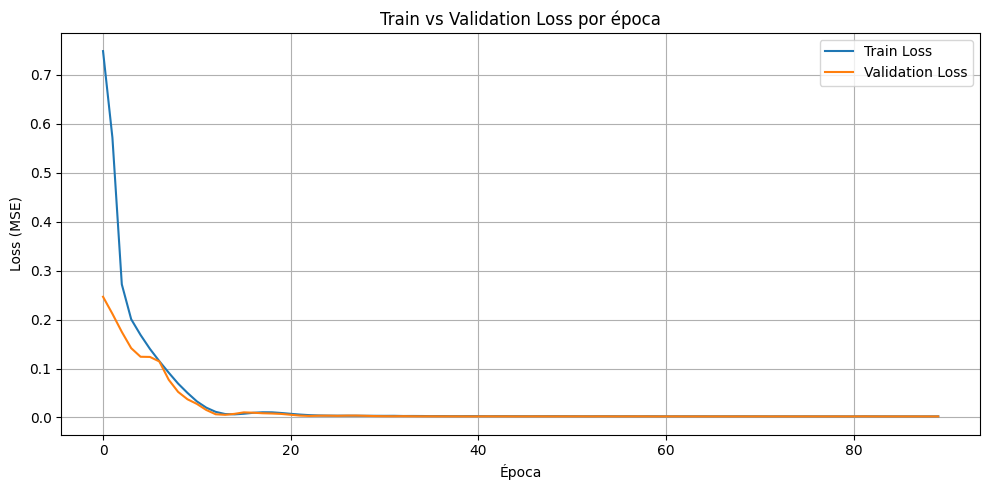


Tiempo total de entrenamiento: 143.52 segundos
MAE: 0.0346
RMSE: 0.0450
R²: 0.8907
MAPE: 8.3571%


In [ ]:

import os
import tempfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

start_time = time.time()
# Métricas
def calculate_rmse(pred, y):
    return np.sqrt(np.mean((pred - y) ** 2))
def calculate_r2(pred, y):
    ss_res = np.sum((y - pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)
def calculate_mape(pred, y):
    return np.mean(np.abs((y - pred) / y)) * 100

# Carga y preprocesamiento de datos

df = pd.read_csv('/content/drive/MyDrive/datasets/Datos_normalizados_corregido.csv',
                 sep=",", header=0, parse_dates=['time'])

df['time'] = df['time'].dt.floor('d')

# Características cíclicas
df['dayofweek'] = df['time'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df_grouped = df.groupby(['time', 'Nombre_loc'], as_index=False).mean()
df_grouped = df_grouped.sort_values(by=['time', 'Nombre_loc']).reset_index(drop=True)

n_ubicaciones = df_grouped['Nombre_loc'].nunique()
numeric_cols = df_grouped.columns[2:]
data_numeric = df_grouped[numeric_cols].values.astype(np.float32)
t2m_index = list(numeric_cols).index('t2m')

# tensor
data_tensor = torch.tensor(data_numeric, dtype=torch.float32)


# Dataset y DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, n_ubicaciones, input_window, output_window, t2m_idx, start=0, end=None):
        self.data = data
        self.n_ubicaciones = n_ubicaciones
        self.input_window = input_window
        self.output_window = output_window
        self.t2m_idx = t2m_idx
        self.window_size = input_window + output_window
        self.total_days = data.shape[0] // n_ubicaciones
        self.end = end if end else self.total_days - self.window_size + 1
        self.start = start

    def __len__(self):
        return self.end - self.start

    def __getitem__(self, idx):
        j = self.start + idx
        input_start = j * self.n_ubicaciones
        input_end = (j + self.input_window) * self.n_ubicaciones
        x = self.data[input_start:input_end].view(self.input_window, self.n_ubicaciones, -1)

        output_start = (j + self.input_window) * self.n_ubicaciones
        output_end = (j + self.input_window + self.output_window) * self.n_ubicaciones
        y = self.data[output_start:output_end][:, t2m_index].view(self.output_window, self.n_ubicaciones, 1)

        return x, y

n_dias_entrada = 7
n_dias_salida = 5
input_window_size = n_dias_entrada
output_window_size = n_dias_salida

# División train/test
n_total = data_tensor.shape[0] // n_ubicaciones
n_samples = n_total - (input_window_size + output_window_size) + 1
train_samples = int(n_samples * 0.8)

train_dataset = TimeSeriesDataset(data_tensor, n_ubicaciones, input_window_size,
                                 output_window_size, t2m_index, end=train_samples)
test_dataset = TimeSeriesDataset(data_tensor, n_ubicaciones, input_window_size,
                                output_window_size, t2m_index, start=train_samples)

batch_size = 1028
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#Modelo GRU

class GRUModel(nn.Module):
    def __init__(self, input_window, output_window, n_ubicaciones, input_features, t2m_idx):
        super().__init__()
        self.input_window = input_window
        self.output_window = output_window
        self.n_ubicaciones = n_ubicaciones
        self.input_features = input_features
        self.flatten_dim = n_ubicaciones * input_features
        #self.t2m_idx = t2m_idx
        #self.alpha = nn.Parameter(torch.ones(1))

        # Encoder
        self.gru1 = nn.GRU(
            self.flatten_dim,
            128,
            batch_first=True,
            dropout=0.19,
            num_layers=2
        )
        self.bn1 = nn.BatchNorm1d(128)

        # Decoder
        self.gru2 = nn.GRU(
            128,
            128,
            batch_first=True,
            dropout=0.15,
            num_layers=2
        )
        self.bn2 = nn.BatchNorm1d(128)

        # Salida
        self.dense = nn.Linear(128, n_ubicaciones)

    def forward(self, x):
      batch_size = x.size(0)

      # Reshape y Encoder
      x = x.reshape(batch_size, self.input_window, -1)
      x, _ = self.gru1(x)
      x = self.bn1(x.reshape(-1, 128)).reshape(batch_size, self.input_window, 128)

      # Último paso del encoder
      last_step = x[:, -1, :]
      repeated = last_step.unsqueeze(1).repeat(1, self.output_window, 1)

      # Decoder
      decoded, _ = self.gru2(repeated)
      decoded = self.bn2(decoded.reshape(-1, 128)).reshape(batch_size, self.output_window, 128)

      # Predicción
      output = self.dense(decoded)
      output = output.unsqueeze(-1)

      # Conexión residual QUITADO
      #last_t2m = x[:, -1, :].reshape(batch_size, self.n_ubicaciones, self.input_features)[:, :, self.t2m_idx]  # [batch_size, n_ubicaciones]
      #last_t2m = last_t2m.unsqueeze(1).unsqueeze(-1).repeat(1, self.output_window, 1, 1)  # [batch_size, output_window, n_ubicaciones, 1]

      #return output + self.alpha * last_t2m
      return output
model = GRUModel(input_window_size, output_window_size, n_ubicaciones,
                len(numeric_cols), t2m_index).to(device)


# Configuración de entrenamiento

optimizer = optim.AdamW(model.parameters(), lr=0.0056, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
loss_fn = nn.MSELoss()

# Early Stopping
best_loss = np.inf
patience = 15
epochs_no_improve = 0


# Entrenamiento

train_losses = []
val_losses = []

for epoch in range(90):
    # Entrenamiento
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item() * X.size(0)

    # Calcular promedios
    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss / len(test_dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Actualizar LR
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model2.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


# Evaluación y gráficos

model.load_state_dict(torch.load('best_model2.pth'))
model.eval()

# Graficar pérdidas para detectar sobreajuste
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_vs_val_loss.png")
plt.show()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTiempo total de entrenamiento: {elapsed_time:.2f} segundos")


with torch.no_grad():
    X, y = next(iter(test_loader))
    X, y = X.to(device), y.to(device)
    pred = model(X).cpu().numpy()
    y = y.cpu().numpy()

    # Calcular métricas
    mae = np.mean(np.abs(pred - y))
    rmse = calculate_rmse(pred, y)
    r2 = calculate_r2(pred, y)
    mape = calculate_mape(pred, y)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'MAPE: {mape:.4f}%')



Modelo cargado desde best_model2.pth


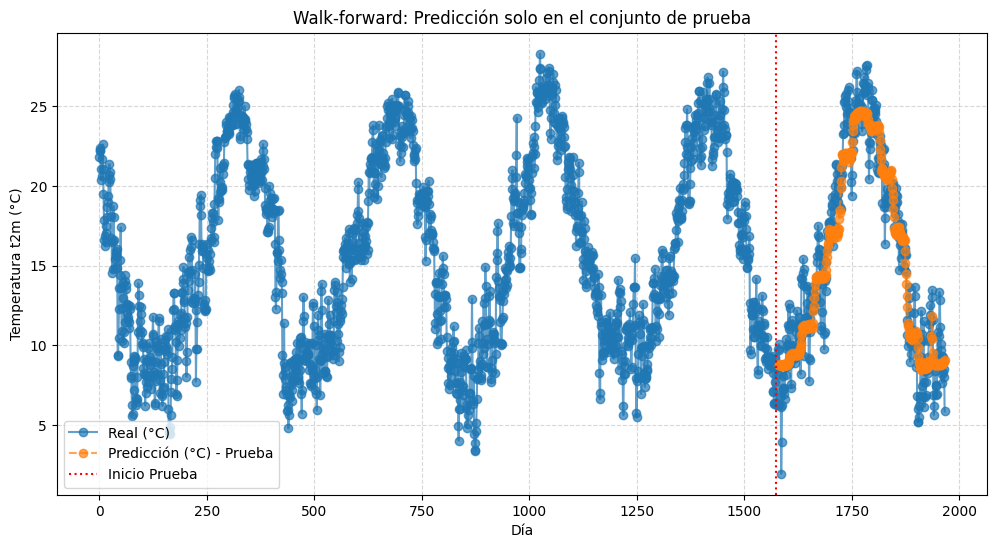

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Valores reales de t2m en Kelvin para la desnormalización
min_val = 264.0
max_val = 314.0

def desnormalizar(value_norm):
    return value_norm * (max_val - min_val) + min_val

def kelvin_a_celsius(valor_k):
    return valor_k - 273.15

# Cargar el modelo entrenado
model = GRUModel(input_window_size, output_window_size, n_ubicaciones,
                 len(numeric_cols), t2m_index).to(device)
model.load_state_dict(torch.load('best_model2.pth', weights_only=True))
model.eval()
print("Modelo cargado desde best_model2.pth")

# Función para extraer una ventana de tamaño
def obtener_ventana(data_tensor, n_ubicaciones, index, window_size):
    start_idx = index * n_ubicaciones
    end_idx = start_idx + window_size * n_ubicaciones
    full_window = data_tensor[start_idx:end_idx]
    return full_window

# Parámetros
n_samples = len(train_dataset) + len(test_dataset)
input_window_size = 7
output_window_size = 5
window_size = input_window_size + output_window_size

test_start_idx = len(train_dataset)

test_pred_final = np.full(n_samples, np.nan, dtype=float)

# Recorremos día a día dentro del conjunto de prueba
ultimo_dia_inicio = n_samples - window_size

for day in range(test_start_idx, ultimo_dia_inicio + 1):
    # Extraer la ventana completa
    full_window = obtener_ventana(data_tensor, n_ubicaciones, day, window_size)
    X_window = full_window[:input_window_size * n_ubicaciones]
    X_window = X_window.view(input_window_size, n_ubicaciones, -1).unsqueeze(0).to(device)

    # Predecir
    with torch.no_grad():
        y_pred = model(X_window).cpu().numpy()

    pred_promedio_norm = y_pred[0, :, :, 0].mean(axis=1)
    pred_promedio_kelvin = desnormalizar(pred_promedio_norm)
    pred_promedio_celsius = kelvin_a_celsius(pred_promedio_kelvin)

    # Guardamos la predicción en el conjunto de prueba
    for i in range(output_window_size):
        dia_predicho = day + input_window_size + i
        if dia_predicho < n_samples:
            test_pred_final[dia_predicho] = pred_promedio_celsius[i]

# Obtener la serie real completa
ground_truth = np.zeros(n_samples, dtype=float)
for d in range(n_samples):
    day_data = data_tensor[d * n_ubicaciones : (d + 1) * n_ubicaciones]
    day_mean = day_data[:, t2m_index].mean().item()
    ground_truth[d] = kelvin_a_celsius(desnormalizar(day_mean))

# Graficar el conjunto de datos completo con predicciones en la parte de prueba
dias = np.arange(n_samples)
plt.figure(figsize=(12, 6))
plt.plot(dias, ground_truth, label='Real (°C)', marker='o', alpha=0.7)
plt.plot(dias, test_pred_final, label='Predicción (°C) - Prueba', marker='o', linestyle='--', alpha=0.7)
plt.axvline(x=test_start_idx, color='r', linestyle='dotted', label='Inicio Prueba')
plt.xlabel('Día')
plt.ylabel('Temperatura t2m (°C)')
plt.title('Walk-forward: Predicción solo en el conjunto de prueba')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Modelo cargado desde best_model.pth
Índices de ventanas elegidas para predicción: [1915 1815 1610 1855 1615]

Ventana de test (índice 1915):
 Día 1:
   Real  (norm) = 0.3207 | Real  (K) = 280.03 | Real  (°C) = 6.88
   Pred  (norm) = 0.3571 | Pred  (K) = 281.85 | Pred  (°C) = 8.70
 Día 2:
   Real  (norm) = 0.3364 | Real  (K) = 280.82 | Real  (°C) = 7.67
   Pred  (norm) = 0.3569 | Pred  (K) = 281.85 | Pred  (°C) = 8.70
 Día 3:
   Real  (norm) = 0.3539 | Real  (K) = 281.69 | Real  (°C) = 8.54
   Pred  (norm) = 0.3595 | Pred  (K) = 281.97 | Pred  (°C) = 8.82
 Día 4:
   Real  (norm) = 0.3521 | Real  (K) = 281.60 | Real  (°C) = 8.45
   Pred  (norm) = 0.3575 | Pred  (K) = 281.87 | Pred  (°C) = 8.72
 Día 5:
   Real  (norm) = 0.3564 | Real  (K) = 281.82 | Real  (°C) = 8.67
   Pred  (norm) = 0.3568 | Pred  (K) = 281.84 | Pred  (°C) = 8.69


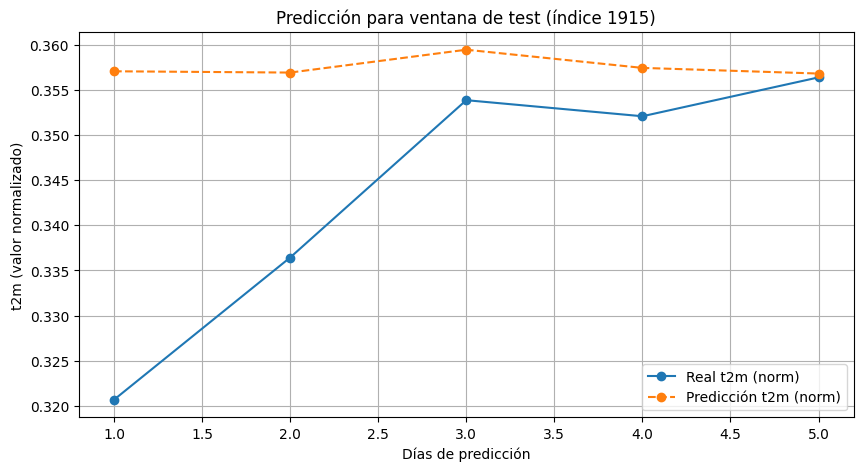


Ventana de test (índice 1815):
 Día 1:
   Real  (norm) = 0.6286 | Real  (K) = 295.43 | Real  (°C) = 22.28
   Pred  (norm) = 0.6001 | Pred  (K) = 294.01 | Pred  (°C) = 20.86
 Día 2:
   Real  (norm) = 0.6069 | Real  (K) = 294.35 | Real  (°C) = 21.20
   Pred  (norm) = 0.6013 | Pred  (K) = 294.07 | Pred  (°C) = 20.92
 Día 3:
   Real  (norm) = 0.6102 | Real  (K) = 294.51 | Real  (°C) = 21.36
   Pred  (norm) = 0.5986 | Pred  (K) = 293.93 | Pred  (°C) = 20.78
 Día 4:
   Real  (norm) = 0.6297 | Real  (K) = 295.48 | Real  (°C) = 22.33
   Pred  (norm) = 0.5964 | Pred  (K) = 293.82 | Pred  (°C) = 20.67
 Día 5:
   Real  (norm) = 0.5566 | Real  (K) = 291.83 | Real  (°C) = 18.68
   Pred  (norm) = 0.5962 | Pred  (K) = 293.81 | Pred  (°C) = 20.66


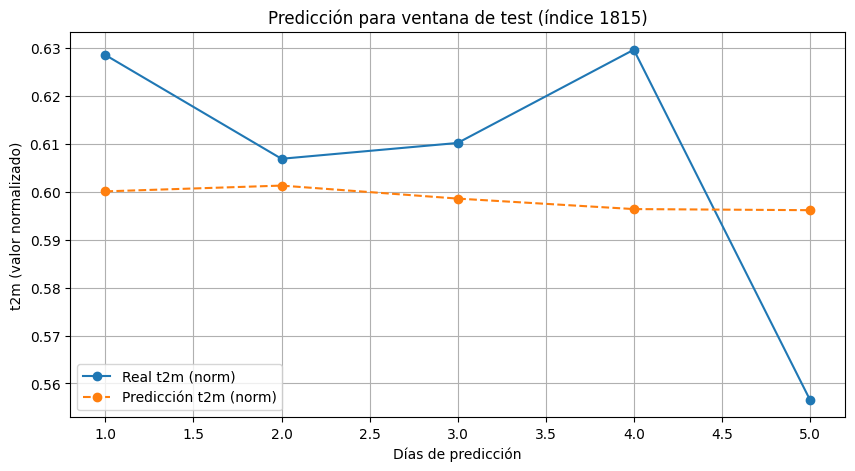


Ventana de test (índice 1610):
 Día 1:
   Real  (norm) = 0.3665 | Real  (K) = 282.33 | Real  (°C) = 9.18
   Pred  (norm) = 0.3703 | Pred  (K) = 282.52 | Pred  (°C) = 9.37
 Día 2:
   Real  (norm) = 0.3786 | Real  (K) = 282.93 | Real  (°C) = 9.78
   Pred  (norm) = 0.3709 | Pred  (K) = 282.54 | Pred  (°C) = 9.39
 Día 3:
   Real  (norm) = 0.3605 | Real  (K) = 282.03 | Real  (°C) = 8.88
   Pred  (norm) = 0.3729 | Pred  (K) = 282.64 | Pred  (°C) = 9.49
 Día 4:
   Real  (norm) = 0.3717 | Real  (K) = 282.59 | Real  (°C) = 9.44
   Pred  (norm) = 0.3750 | Pred  (K) = 282.75 | Pred  (°C) = 9.60
 Día 5:
   Real  (norm) = 0.4000 | Real  (K) = 284.00 | Real  (°C) = 10.85
   Pred  (norm) = 0.3758 | Pred  (K) = 282.79 | Pred  (°C) = 9.64


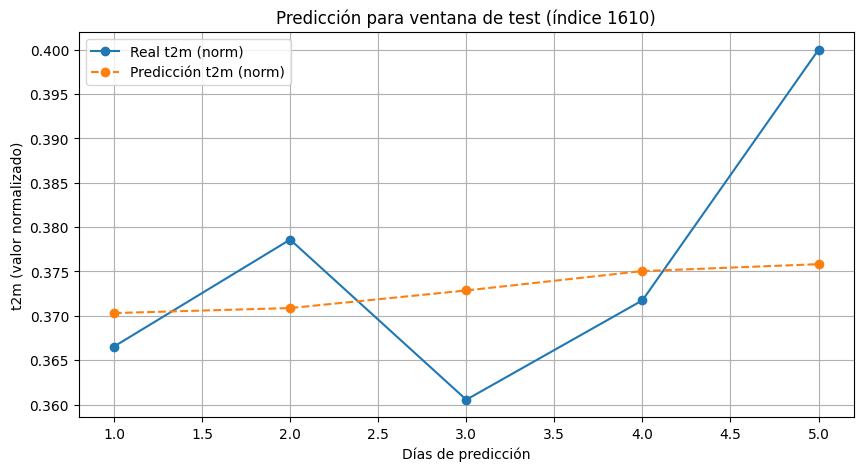


Ventana de test (índice 1855):
 Día 1:
   Real  (norm) = 0.5357 | Real  (K) = 290.79 | Real  (°C) = 17.64
   Pred  (norm) = 0.5228 | Pred  (K) = 290.14 | Pred  (°C) = 16.99
 Día 2:
   Real  (norm) = 0.5095 | Real  (K) = 289.48 | Real  (°C) = 16.33
   Pred  (norm) = 0.5232 | Pred  (K) = 290.16 | Pred  (°C) = 17.01
 Día 3:
   Real  (norm) = 0.4920 | Real  (K) = 288.60 | Real  (°C) = 15.45
   Pred  (norm) = 0.5185 | Pred  (K) = 289.93 | Pred  (°C) = 16.78
 Día 4:
   Real  (norm) = 0.5119 | Real  (K) = 289.59 | Real  (°C) = 16.44
   Pred  (norm) = 0.5145 | Pred  (K) = 289.73 | Pred  (°C) = 16.58
 Día 5:
   Real  (norm) = 0.5245 | Real  (K) = 290.22 | Real  (°C) = 17.07
   Pred  (norm) = 0.5133 | Pred  (K) = 289.67 | Pred  (°C) = 16.52


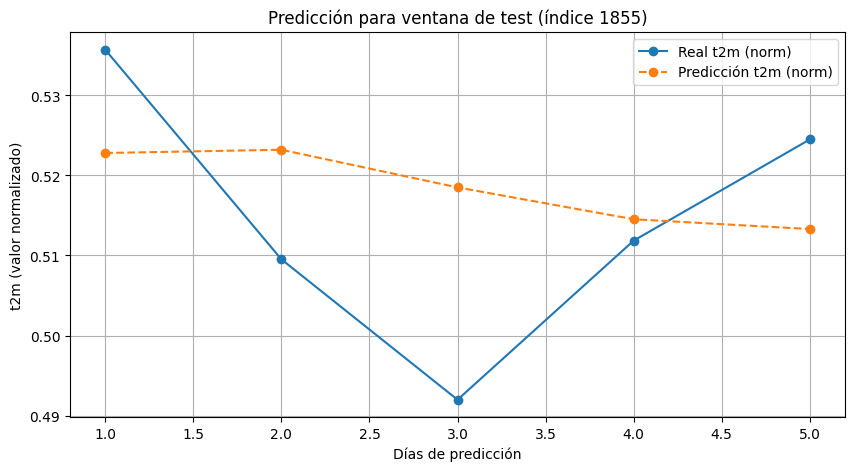


Ventana de test (índice 1615):
 Día 1:
   Real  (norm) = 0.4266 | Real  (K) = 285.33 | Real  (°C) = 12.18
   Pred  (norm) = 0.3717 | Pred  (K) = 282.59 | Pred  (°C) = 9.44
 Día 2:
   Real  (norm) = 0.4048 | Real  (K) = 284.24 | Real  (°C) = 11.09
   Pred  (norm) = 0.3716 | Pred  (K) = 282.58 | Pred  (°C) = 9.43
 Día 3:
   Real  (norm) = 0.3817 | Real  (K) = 283.08 | Real  (°C) = 9.93
   Pred  (norm) = 0.3728 | Pred  (K) = 282.64 | Pred  (°C) = 9.49
 Día 4:
   Real  (norm) = 0.3939 | Real  (K) = 283.70 | Real  (°C) = 10.55
   Pred  (norm) = 0.3745 | Pred  (K) = 282.72 | Pred  (°C) = 9.57
 Día 5:
   Real  (norm) = 0.4100 | Real  (K) = 284.50 | Real  (°C) = 11.35
   Pred  (norm) = 0.3749 | Pred  (K) = 282.74 | Pred  (°C) = 9.59


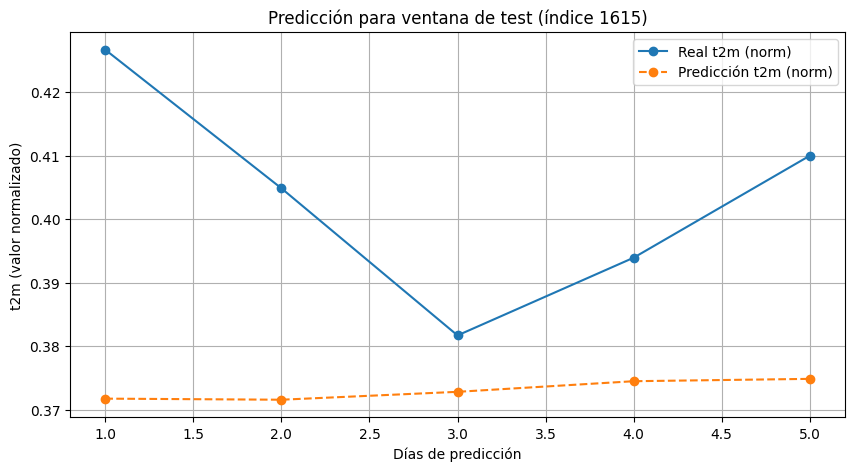

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

min_val = 264.0
max_val = 314.0
def desnormalizar(value_norm):
    return value_norm * (max_val - min_val) + min_val
def kelvin_a_celsius(valor_k):
    return valor_k - 273.15

# Cargar el modelo entrenado
model = GRUModel(input_window_size, output_window_size, n_ubicaciones,
                len(numeric_cols), t2m_index).to(device)
model.load_state_dict(torch.load('best_model2.pth', weights_only=True))
model.eval()
print("Modelo cargado desde best_model.pth")

# extraer una ventana
def obtener_ventana(data_tensor, n_ubicaciones, index, window_size, input_window_size, output_window_size, t2m_index):
    """
    Extrae una ventana de datos (entrada y salida) a partir del índice dado.
      - index: índice de la ventana en días.
      - data_tensor: datos normalizados (tensor PyTorch).
    """
    start_idx = index * n_ubicaciones
    end_idx = start_idx + window_size * n_ubicaciones
    full_window = data_tensor[start_idx:end_idx]

    # Ventana de entrada
    X_window = full_window[: input_window_size * n_ubicaciones]
    X_window = X_window.view(input_window_size, n_ubicaciones, -1)

    # Ventana de salida
    y_window = full_window[input_window_size * n_ubicaciones:]
    y_window = y_window.view(output_window_size, n_ubicaciones, -1)
    y_window = y_window[..., [t2m_index]]

    return X_window, y_window

n_samples = len(test_dataset) + len(train_dataset)
train_samples = len(train_dataset)
input_window_size = 7
output_window_size = 5
window_size = input_window_size + output_window_size

# Número de ventanas aleatorias a evaluar
num_ventanas = 5

indices_test = np.arange(train_samples, n_samples)
indices_aleatorios = np.random.choice(indices_test, size=num_ventanas, replace=False)

print("Índices de ventanas elegidas para predicción:", indices_aleatorios)

# Iterar sobre cada ventana seleccionada y graficar las predicciones
for idx in indices_aleatorios:
    X_window, y_window = obtener_ventana(data_tensor, n_ubicaciones, idx,
                                        window_size, input_window_size, output_window_size, t2m_index)
    X_window_batch = X_window.unsqueeze(0).to(device)

    # predicción
    with torch.no_grad():
        y_pred_window = model(X_window_batch).cpu()

    y_window_np = y_window.numpy()
    y_pred_np = y_pred_window.numpy()
    real_promedio = y_window_np[..., 0].mean(axis=1)
    pred_promedio = y_pred_np[0, ..., 0].mean(axis=1)

    # Desnormalizar
    real_kelvin = desnormalizar(real_promedio)
    real_celsius = kelvin_a_celsius(real_kelvin)
    pred_kelvin = desnormalizar(pred_promedio)
    pred_celsius = kelvin_a_celsius(pred_kelvin)

    # Imprimir
    print(f"\nVentana de test (índice {idx}):")
    for dia in range(output_window_size):
        print(f" Día {dia+1}:")
        print(f"   Real  (norm) = {real_promedio[dia]:.4f} | Real  (K) = {real_kelvin[dia]:.2f} | Real  (°C) = {real_celsius[dia]:.2f}")
        print(f"   Pred  (norm) = {pred_promedio[dia]:.4f} | Pred  (K) = {pred_kelvin[dia]:.2f} | Pred  (°C) = {pred_celsius[dia]:.2f}")

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, output_window_size + 1), real_promedio, marker='o', label='Real t2m (norm)')
    plt.plot(range(1, output_window_size + 1), pred_promedio, marker='o', linestyle='--', label='Predicción t2m (norm)')
    plt.title(f'Predicción para ventana de test (índice {idx})')
    plt.xlabel('Días de predicción')
    plt.ylabel('t2m (valor normalizado)')
    plt.legend()
    plt.grid(True)
    plt.show()

# T2M LSTM

Using device: cpu
Epoch 1: Train Loss: 0.7299, Val Loss: 0.2336
Epoch 2: Train Loss: 0.5048, Val Loss: 0.2000
Epoch 3: Train Loss: 0.2432, Val Loss: 0.1760
Epoch 4: Train Loss: 0.1855, Val Loss: 0.1516
Epoch 5: Train Loss: 0.1573, Val Loss: 0.1246
Epoch 6: Train Loss: 0.1259, Val Loss: 0.1002
Epoch 7: Train Loss: 0.1017, Val Loss: 0.0813
Epoch 8: Train Loss: 0.0776, Val Loss: 0.0621
Epoch 9: Train Loss: 0.0560, Val Loss: 0.0433
Epoch 10: Train Loss: 0.0380, Val Loss: 0.0294
Epoch 11: Train Loss: 0.0231, Val Loss: 0.0181
Epoch 12: Train Loss: 0.0137, Val Loss: 0.0136
Epoch 13: Train Loss: 0.0097, Val Loss: 0.0123
Epoch 14: Train Loss: 0.0082, Val Loss: 0.0132
Epoch 15: Train Loss: 0.0098, Val Loss: 0.0162
Epoch 16: Train Loss: 0.0110, Val Loss: 0.0143
Epoch 17: Train Loss: 0.0109, Val Loss: 0.0114
Epoch 18: Train Loss: 0.0102, Val Loss: 0.0092
Epoch 19: Train Loss: 0.0086, Val Loss: 0.0079
Epoch 20: Train Loss: 0.0068, Val Loss: 0.0062
Epoch 21: Train Loss: 0.0057, Val Loss: 0.0047
Epoc

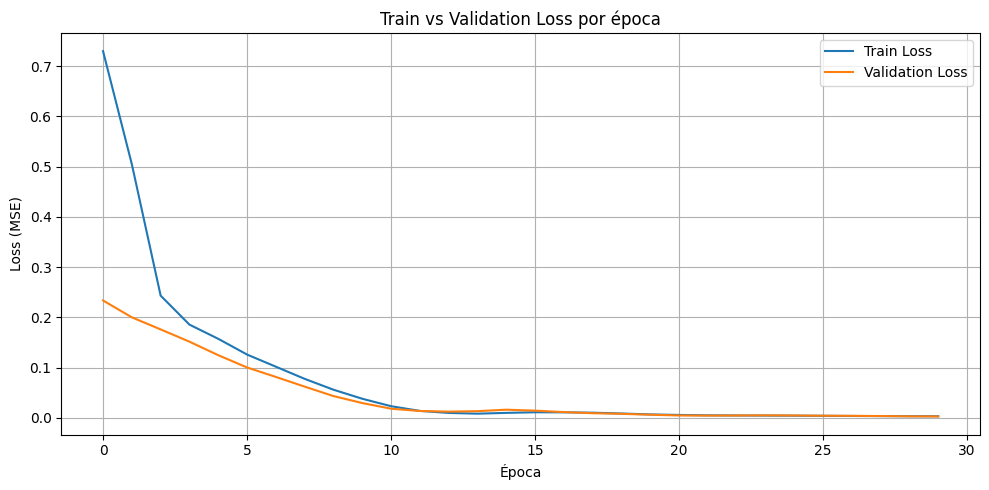

MAE: 0.0419
RMSE: 0.0520
R²: 0.8543
MAPE: 9.7003%

 Tiempo total de ejecución: 1 min 53 seg


In [ ]:
import os
import tempfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
start_time = time.time()

# Métricas
def calculate_rmse(pred, y):
    return np.sqrt(np.mean((pred - y) ** 2))

def calculate_r2(pred, y):
    ss_res = np.sum((y - pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mape(pred, y):
    return np.mean(np.abs((y - pred) / y)) * 100

# 1. Carga y preprocesamiento de datos

df = pd.read_csv('/content/drive/MyDrive/datasets/Datos_normalizados_corregido.csv',
                 sep=",", header=0, parse_dates=['time'])

df['time'] = df['time'].dt.floor('d')

df['dayofweek'] = df['time'].dt.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df_grouped = df.groupby(['time', 'Nombre_loc'], as_index=False).mean()
df_grouped = df_grouped.sort_values(by=['time', 'Nombre_loc']).reset_index(drop=True)

n_ubicaciones = df_grouped['Nombre_loc'].nunique()
numeric_cols = df_grouped.columns[2:]
data_numeric = df_grouped[numeric_cols].values.astype(np.float32)
t2m_index = list(numeric_cols).index('t2m')

data_tensor = torch.tensor(data_numeric, dtype=torch.float32)

# 2. Dataset y DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, n_ubicaciones, input_window, output_window, t2m_idx, start=0, end=None):
        self.data = data
        self.n_ubicaciones = n_ubicaciones
        self.input_window = input_window
        self.output_window = output_window
        self.t2m_idx = t2m_idx
        self.window_size = input_window + output_window
        self.total_days = data.shape[0] // n_ubicaciones
        self.end = end if end else self.total_days - self.window_size + 1
        self.start = start

    def __len__(self):
        return self.end - self.start

    def __getitem__(self, idx):
        j = self.start + idx
        input_start = j * self.n_ubicaciones
        input_end = (j + self.input_window) * self.n_ubicaciones
        x = self.data[input_start:input_end].view(self.input_window, self.n_ubicaciones, -1)

        output_start = (j + self.input_window) * self.n_ubicaciones
        output_end = (j + self.input_window + self.output_window) * self.n_ubicaciones
        y = self.data[output_start:output_end][:, t2m_index].view(self.output_window, self.n_ubicaciones, 1)

        return x, y

n_dias_entrada = 7
n_dias_salida = 5
input_window_size = n_dias_entrada
output_window_size = n_dias_salida

n_total = data_tensor.shape[0] // n_ubicaciones
n_samples = n_total - (input_window_size + output_window_size) + 1
train_samples = int(n_samples * 0.8)

train_dataset = TimeSeriesDataset(data_tensor, n_ubicaciones, input_window_size,
                                 output_window_size, t2m_index, end=train_samples)
test_dataset = TimeSeriesDataset(data_tensor, n_ubicaciones, input_window_size,
                                output_window_size, t2m_index, start=train_samples)

batch_size = 1028
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Modelo LSTM

class LSTMModel(nn.Module):
    def __init__(self, input_window, output_window, n_ubicaciones, input_features):
        super().__init__()
        self.input_window = input_window
        self.output_window = output_window
        self.n_ubicaciones = n_ubicaciones
        self.input_features = input_features
        self.flatten_dim = n_ubicaciones * input_features

        self.lstm1 = nn.LSTM(self.flatten_dim, 128, num_layers=2, dropout=0.19, batch_first=True)
        self.bn1 = nn.BatchNorm1d(128)

        self.lstm2 = nn.LSTM(128, 128, num_layers=2, dropout=0.15, batch_first=True)
        self.bn2 = nn.BatchNorm1d(128)

        self.dense = nn.Linear(128, n_ubicaciones)

    def forward(self, x):
        batch_size = x.size(0)

        x = x.reshape(batch_size, self.input_window, -1)
        x, _ = self.lstm1(x)
        x = self.bn1(x.reshape(-1, 128)).reshape(batch_size, self.input_window, 128)

        last_step = x[:, -1, :]
        repeated = last_step.unsqueeze(1).repeat(1, self.output_window, 1)

        decoded, _ = self.lstm2(repeated)
        decoded = self.bn2(decoded.reshape(-1, 128)).reshape(batch_size, self.output_window, 128)

        output = self.dense(decoded)
        output = output.unsqueeze(-1)

        return output

model = LSTMModel(input_window_size, output_window_size, n_ubicaciones, len(numeric_cols)).to(device)

# 4. Configuración de entrenamiento

optimizer = optim.AdamW(model.parameters(), lr=0.0056, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
loss_fn = nn.MSELoss()

best_loss = np.inf
patience = 5
epochs_no_improve = 0

train_losses = []
val_losses = []

# 5. Entrenamiento

for epoch in range(30):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item() * X.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(test_dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# 6. Evaluación y métricas

model.load_state_dict(torch.load('best_lstm_model.pth'))
model.eval()
# Graficar pérdidas para detectar sobreajuste
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_vs_val_loss.png")
plt.show()

with torch.no_grad():
    X, y = next(iter(test_loader))
    X, y = X.to(device), y.to(device)
    pred = model(X).cpu().numpy()
    y = y.cpu().numpy()

    mae = np.mean(np.abs(pred - y))
    rmse = calculate_rmse(pred, y)
    r2 = calculate_r2(pred, y)
    mape = calculate_mape(pred, y)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'MAPE: {mape:.4f}%')
end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"\n Tiempo total de ejecución: {int(minutes)} min {int(seconds)} seg")

# **CAPE**

Entrenamiento: 78680 muestras, Test: 15680 muestras


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:02:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.05367	test-rmse:0.05543
[50]	train-rmse:0.03138	test-rmse:0.03233
[100]	train-rmse:0.03139	test-rmse:0.03229
[150]	train-rmse:0.03139	test-rmse:0.03233
[200]	train-rmse:0.03142	test-rmse:0.03237
[250]	train-rmse:0.03139	test-rmse:0.03238
[300]	train-rmse:0.03139	test-rmse:0.03230
[350]	train-rmse:0.03140	test-rmse:0.03239
[400]	train-rmse:0.03141	test-rmse:0.03235
[450]	train-rmse:0.03137	test-rmse:0.03229
[500]	train-rmse:0.03136	test-rmse:0.03231
[550]	train-rmse:0.03138	test-rmse:0.03230
[600]	train-rmse:0.03139	test-rmse:0.03238
[650]	train-rmse:0.03140	test-rmse:0.03237
[700]	train-rmse:0.03141	test-rmse:0.03230
[750]	train-rmse:0.03140	test-rmse:0.03230
[800]	train-rmse:0.03138	test-rmse:0.03234
[850]	train-rmse:0.03138	test-rmse:0.03230
[900]	train-rmse:0.03138	test-rmse:0.03232
[921]	train-rmse:0.03139	test-rmse:0.03233


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:07:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:07:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Modelo guardado como 'xgboost_cape_model.model'

RMSE: 0.0323
MAE: 0.0122
R²: 0.6842


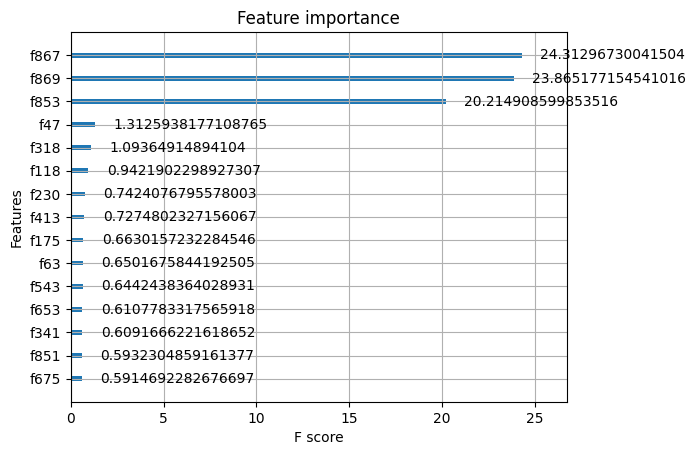

In [ ]:
# CAPE ENTRENAMIENTO
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Clase Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, n_ubicaciones, input_window, output_window, cape_idx, start_day=0, end_day=None):
        self.data = data
        self.n_ubicaciones = n_ubicaciones
        self.input_window = input_window
        self.output_window = output_window
        self.cape_idx = cape_idx
        self.window_size = input_window + output_window
        self.total_days = data.shape[0] // n_ubicaciones
        self.end_day = end_day if end_day else self.total_days - self.window_size
        self.start_day = start_day

    def __len__(self):
        return self.end_day - self.start_day - self.window_size + 1

    def __getitem__(self, idx):
        j = self.start_day + idx
        if j + self.window_size > self.total_days:
            raise IndexError(f"Índice fuera de rango: {j} (total días: {self.total_days})")

        input_start = j * self.n_ubicaciones
        input_end = (j + self.input_window) * self.n_ubicaciones
        x = self.data[input_start:input_end].view(self.input_window, self.n_ubicaciones, -1)

        output_start = (j + self.input_window) * self.n_ubicaciones
        output_end = (j + self.input_window + self.output_window) * self.n_ubicaciones
        y = self.data[output_start:output_end, self.cape_idx]  # SOLO CAPE

        # Verificación dimensiones
        if y.numel() != self.output_window * self.n_ubicaciones:
            raise ValueError(
                f"Tamaño de y ({y.numel()}) ≠ {self.output_window}x{self.n_ubicaciones}. "
                f"Posible causa: datos incompletos o índices incorrectos."
            )

        return x, y.view(self.output_window, self.n_ubicaciones, 1)

# 2. Extracción de características adaptada a la nueva estructura
def extract_features_targets(dataset):
    features = []
    targets = []

    for x, y in dataset:
        # Aplanar
        flat_features = x.numpy().reshape(x.shape[0], -1)

        # Extraer CAPE y validar dimensiones
        flat_targets = y.numpy()[:, :, 0].flatten()
        if flat_targets.size != dataset.output_window * dataset.n_ubicaciones:
            continue
        for step in range(dataset.output_window):
            time_feat = [
                np.sin(2 * np.pi * (step + 1) / 365),
                np.cos(2 * np.pi * (step + 1) / 365),
                step + 1
            ]

            full_features = np.concatenate([flat_features.flatten(), time_feat])
            for loc in range(dataset.n_ubicaciones):
                features.append(full_features)
                targets.append(flat_targets[step * dataset.n_ubicaciones + loc])

    return np.array(features), np.array(targets)


n_ubicaciones = 8
cape_idx = list(numeric_cols).index('cape')
input_window_size = 7
output_window_size = 5
split_ratio = 0.8


# 3. Creación datasets
n_total_days = data_tensor.shape[0] // n_ubicaciones
train_cutoff_day = int(n_total_days * split_ratio)
train_dataset = TimeSeriesDataset(
    data_tensor,
    n_ubicaciones,
    input_window_size,
    output_window_size,
    cape_idx,
    end_day=train_cutoff_day - output_window_size
)

# Conjunto de prueb
test_dataset = TimeSeriesDataset(
    data_tensor,
    n_ubicaciones,
    input_window_size,
    output_window_size,
    cape_idx,
    start_day=train_cutoff_day - input_window_size
)

# 4. Extracción de características
X_train, y_train = extract_features_targets(train_dataset)
X_test, y_test = extract_features_targets(test_dataset)

# Verificación final
print(f"Entrenamiento: {X_train.shape[0]} muestras, Test: {X_test.shape[0]} muestras")

# 5. Modelo XGBoost
params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': 1.5,
    'eval_metric': 'rmse',
    'learning_rate': 0.6,
    'max_depth': 15,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'alpha': 0.2,
    'lambda': 1.5,
    'tree_method': 'gpu_hist' if torch.cuda.is_available() else 'hist',
    'grow_policy': 'lossguide',
    'max_leaves': 1028
}

# Entrenamiento con validación
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=500,
    verbose_eval=50
)
# 6. Guardar el modelo entrenado
model.save_model('xgboost_cape_model.model')
print("Modelo guardado como 'xgboost_cape_model.model'")
# Evaluación
preds = model.predict(dtest)
print(f'\nRMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}')
print(f'MAE: {mean_absolute_error(y_test, preds):.4f}')
print(f'R²: {r2_score(y_test, preds):.4f}')

# Visualización
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.show()

Número de características esperado por el modelo: 899


<ipython-input-21-fe3f78e81e99>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_normalizado[step, loc] = preds_step


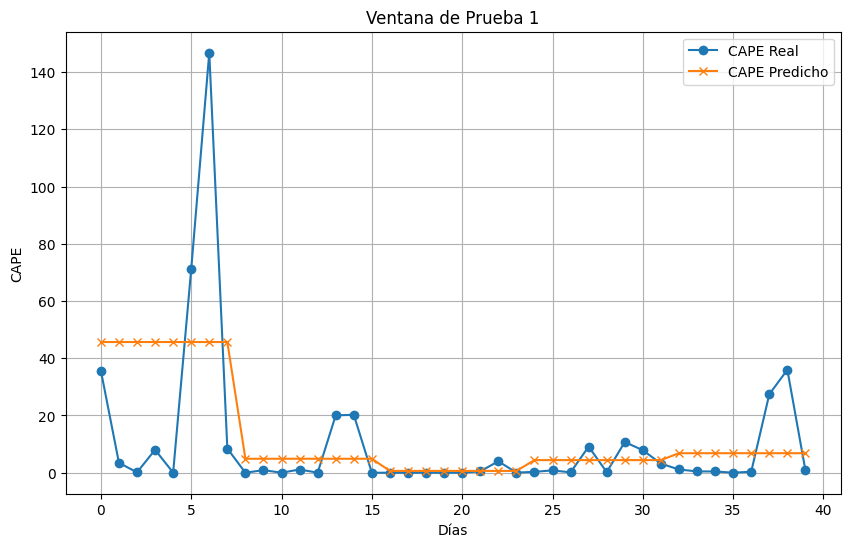


Métricas para Ventana 1:
RMSE: 23.4340
MAE: 13.2299
R²: 0.1794


<ipython-input-21-fe3f78e81e99>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_normalizado[step, loc] = preds_step


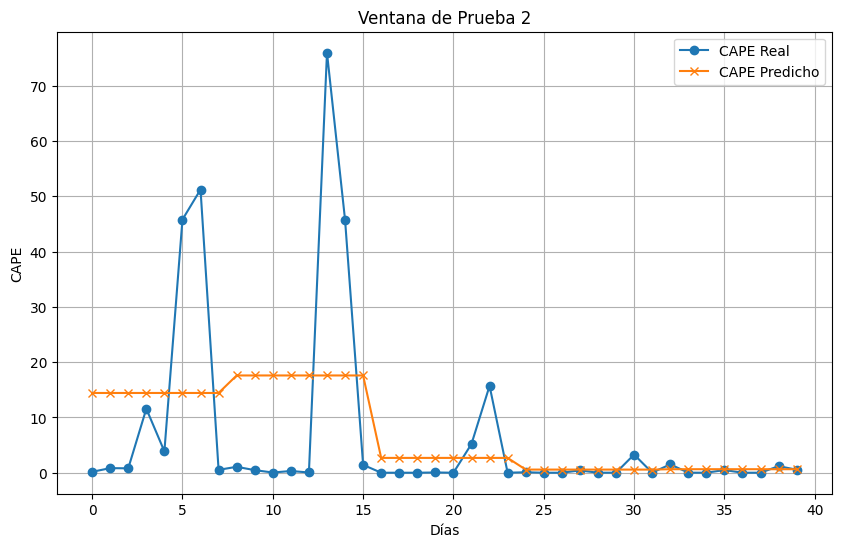


Métricas para Ventana 2:
RMSE: 15.3315
MAE: 9.1934
R²: 0.1629


<ipython-input-21-fe3f78e81e99>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_normalizado[step, loc] = preds_step


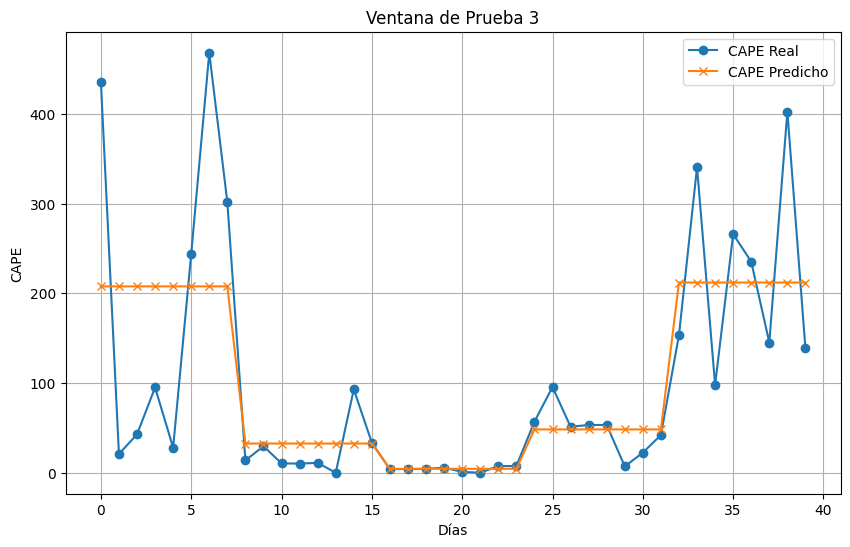


Métricas para Ventana 3:
RMSE: 90.9589
MAE: 57.7905
R²: 0.5109


<ipython-input-21-fe3f78e81e99>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_normalizado[step, loc] = preds_step


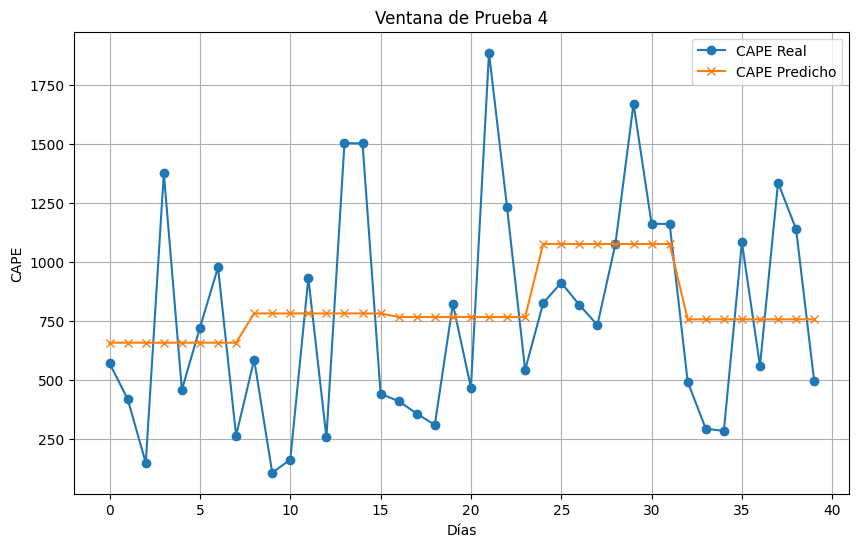


Métricas para Ventana 4:
RMSE: 430.7702
MAE: 364.5774
R²: 0.0931


<ipython-input-21-fe3f78e81e99>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_normalizado[step, loc] = preds_step


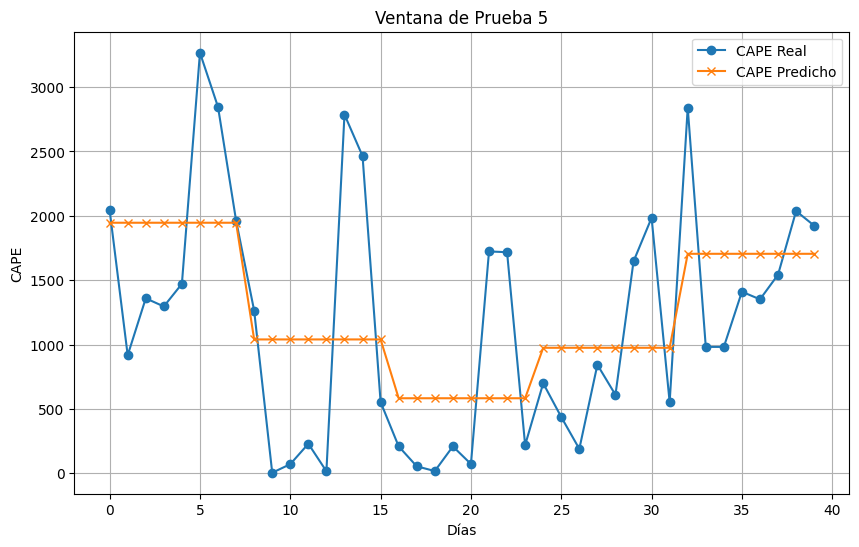


Métricas para Ventana 5:
RMSE: 759.1723
MAE: 648.0272
R²: 0.3056


In [ ]:
### CAPE VISUALIZACION

import numpy as np
import matplotlib.pyplot as plt

# 1. Cargar el modelo entrenado
loaded_model = xgb.Booster()
loaded_model.load_model('xgboost_cape_model.model')
num_feature_esperado = loaded_model.num_features()
print(f"Número de características esperado por el modelo: {num_feature_esperado}")

# 2. Seleccionar varias ventanas de prueba
def seleccionar_ventanas(dataset, num_ventanas=15):
    """
    Selecciona un número específico de ventanas de prueba.
    """
    indices = np.random.choice(len(dataset), num_ventanas, replace=False)
    ventanas = [dataset[i] for i in indices]
    return ventanas

# 3. Función para desnormalizar CAPE
def desnormalizar_cape(cape_normalizado, cape_min, cape_max):
    """
    Desnormaliza los valores de CAPE.
    """
    return cape_normalizado * (cape_max - cape_min) + cape_min

# 4. Valores mínimos y máximos de CAPE (ajusta según tus datos)
cape_min = 0.0
cape_max = 6575.375

# 5. Seleccionar ventanas de prueba
ventanas_prueba = seleccionar_ventanas(test_dataset, num_ventanas=5)

# 6. Evaluar y visualizar las predicciones
for i, (x, y_real) in enumerate(ventanas_prueba):
    flat_features = x.numpy().reshape(x.shape[0], -1)

    # Inicializar array para almacenar predicciones
    y_pred_normalizado = np.zeros((output_window_size, n_ubicaciones))

    # Generar características POR CADA DÍA Y UBICACIÓN
    for step in range(output_window_size):
        for loc in range(n_ubicaciones):
            # Características temporales para el día actual
            time_feat = [
                np.sin(2 * np.pi * (step + 1) / 365),
                np.cos(2 * np.pi * (step + 1) / 365),
                step + 1
            ]

            full_features = np.concatenate([flat_features.flatten(), time_feat])

            # Verificar dimensiones
            if len(full_features) != num_feature_esperado:
                raise ValueError(f"Error en dimensiones: {len(full_features)} != {num_feature_esperado}")

            # Crear DMatrix y predecir
            dventana = xgb.DMatrix(full_features.reshape(1, -1))
            preds_step = loaded_model.predict(dventana)

            # Almacenar predicción para la ubicación actual
            y_pred_normalizado[step, loc] = preds_step

    # Desnormalizar
    y_pred = desnormalizar_cape(y_pred_normalizado.flatten(), cape_min, cape_max)
    y_real = desnormalizar_cape(y_real.numpy().flatten(), cape_min, cape_max)
    plt.figure(figsize=(10, 6))
    plt.plot(y_real, label='CAPE Real', marker='o')
    plt.plot(y_pred, label='CAPE Predicho', marker='x')
    plt.title(f'Ventana de Prueba {i + 1}')
    plt.xlabel('Días')
    plt.ylabel('CAPE')
    plt.legend()
    plt.grid()
    plt.show()

    # Imprimir métricas para la ventana actual
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    print(f"\nMétricas para Ventana {i + 1}:")
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')